# FCN with VGG16 model
### Segmentation method

## Get packages

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow import keras

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from keras.models import *
from keras.layers import *
import tensorflow as tf
import tensorflow as tf

from tqdm import tqdm
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize

from keras.applications.vgg16 import VGG16
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

## Path and size

In [20]:
# s-a ales din setul de date de 468 img 75% pt antrenare si 25% pentru testare si validare

TRAIN_PATH = 'archive/segmentation/no_only_train/neaug/train/'
VALID_PATH = 'archive/segmentation/no_only_train/aug/validation/'
TEST_PATH = 'archive/segmentation/no_only_train/aug/test/'

seed = 42
np.random.seed = seed

train_ids = next(os.walk(TRAIN_PATH))[1]
valid_ids = next(os.walk(VALID_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [21]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3

## Load and Prepare Images

In [22]:

# print('Resizing training images and masks')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
correspondent = {}

#train images
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  # Fill empty X_train with values from img
    correspondent[n] = str(id_)

# #train masks
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask_

# #validation images    
X_valid = np.zeros((len(valid_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_valid = np.zeros((len(valid_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

for n, id_ in tqdm(enumerate(valid_ids), total=len(valid_ids)):
    path = VALID_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_valid[n] = img  # Fill empty X_valid with values from img
    correspondent[n] = str(id_)

# validation masks
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_valid[n] = mask_    
    
    
# # test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
correspondent_test = {}

size_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    size_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    correspondent_test[n] = str(id_)
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_test[n] = mask_
print('Done!')

100%|███████████████████████████████████████████| 70/70 [00:01<00:00, 50.58it/s]


Resizing test images


100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 50.98it/s]

Done!


## Make the model

In [23]:
def make_fcn_vgg16(input_shape, nb_labels, use_pretraining, freeze_base):
    nb_rows, nb_cols, _ = input_shape
    input_tensor = Input(shape=input_shape)
    weights = 'imagenet' if use_pretraining else None
    
# A VGG model with weights from training on ImageNet.
    model = VGG16(
        include_top=False, weights=weights, input_tensor=input_tensor)
    
# Setting backbone to be non-trainable
    if freeze_base:
        for layer in model.layers:
            layer.trainable = False
            
#  Get final 32x32, 16x16, and 8x8 layers in the original
# ResNet by that layers's name.
    x32 = model.get_layer('block3_pool').output 
    x16 = model.get_layer('block4_pool').output 
    x8 = model.get_layer('block5_pool').output 
    
    
# Compress each skip connection so it has nb_labels channels.
    c32 = Conv2D(nb_labels, (1, 1), name='conv_labels_32')(x32)
    c32 = BatchNormalization()(c32)
        
    c16 = Conv2D(nb_labels, (1, 1), name='conv_labels_16')(x16)
    c16 = BatchNormalization()(c16)
    
    c8 = Conv2D(nb_labels, (1, 1), name='conv_labels_8')(x8)
    c8 = BatchNormalization()(c8)
    
# Resize each compressed skip connection using bilinear interpolation.
# This operation isn't built into Keras, so we use a LambdaLayer
# which allows calling a Tensorflow operation.
    def resize_bilinear(images):
        return tf.compat.v1.image.resize_bilinear(images, [nb_rows, nb_cols])

    r32 = Lambda(resize_bilinear, name='resize_labels_32')(c32)
    r16 = Lambda(resize_bilinear, name='resize_labels_16')(c16)
    r8 = Lambda(resize_bilinear, name='resize_labels_8')(c8)
    
# Merge the three layers together using summation.
    m = Add(name='merge_labels')([r32, r16, r8])
    
# Add softmax layer to get probabilities as output. We need to reshape
# and then un-reshape because Keras expects input to softmax to
# be 2D.
    x = Reshape((nb_rows * nb_cols, nb_labels))(m)
    x = Activation('sigmoid')(x)
    x = Reshape((nb_rows, nb_cols, nb_labels))(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model

In [24]:
model = make_fcn_vgg16([224, 224, 3], 1,
                        use_pretraining=True, freeze_base=False)

In [25]:
nb_labels = 1
nb_cols = 224
nb_rows = 224
nb_bands = 3

input_tensor = Input((nb_rows, nb_cols, nb_bands))

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [27]:
# compile the model
model.compile(
              optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )

## Train the model

In [28]:
# Se antreneaza modelul
checkpoiter = tf.keras.callbacks.ModelCheckpoint('FCN_VGG16_valid_neaug.h5', 
                                                 verbose=1, 
                                                 save_best_only=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=0.00001, verbose=1)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpoiter

]
results = model.fit(X_train, 
                    Y_train,
                    validation_data= (X_valid, Y_valid), 
                    shuffle=False,
#                     validation_split=0.1, 
                    batch_size=8, 
                    epochs=25, 
                    callbacks=callbacks,
                   )


Epoch 1/25
44/44 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.6684
Epoch 1: val_loss improved from inf to 2.66140, saving model to FCN_VGG16_valid_neaug.h5
44/44 [==============================] - 140s 3s/step - loss: 0.6085 - accuracy: 0.6684 - val_loss: 2.6614 - val_accuracy: 0.3135
Epoch 2/25
44/44 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.7945
Epoch 2: val_loss improved from 2.66140 to 0.36856, saving model to FCN_VGG16_valid_neaug.h5
44/44 [==============================] - 163s 4s/step - loss: 0.4903 - accuracy: 0.7945 - val_loss: 0.3686 - val_accuracy: 0.9139
Epoch 3/25
44/44 [==============================] - ETA: 0s - loss: 0.4374 - accuracy: 0.8347
Epoch 3: val_loss did not improve from 0.36856
44/44 [==============================] - 217s 5s/step - loss: 0.4374 - accuracy: 0.8347 - val_loss: 0.4745 - val_accuracy: 0.8291
Epoch 4/25
44/44 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.8606
Epoch

## Results

### During training

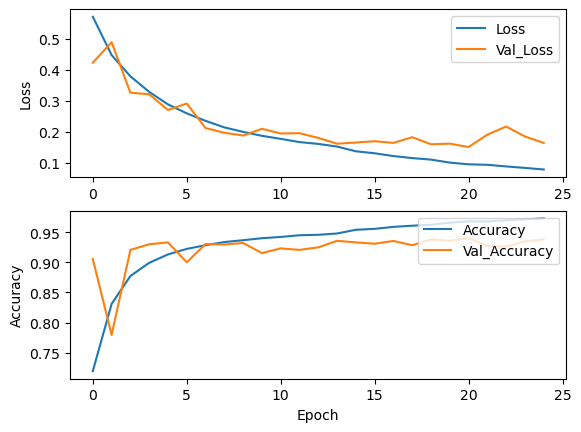

In [12]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Get predictions

In [29]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


2/2 [==============================] - 6s 2s/step


In [30]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))
print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.9301601052284241
Loss Score =  0.24759477376937866


### Test the model

Image number:  41


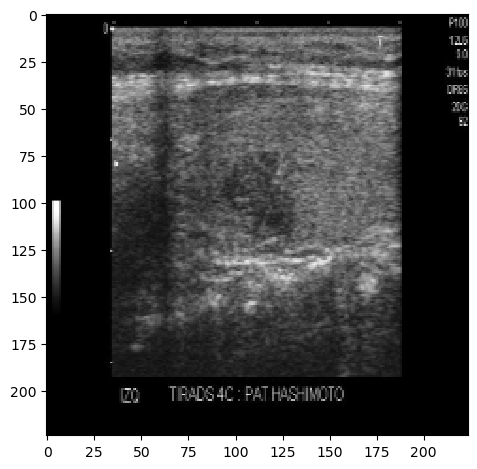

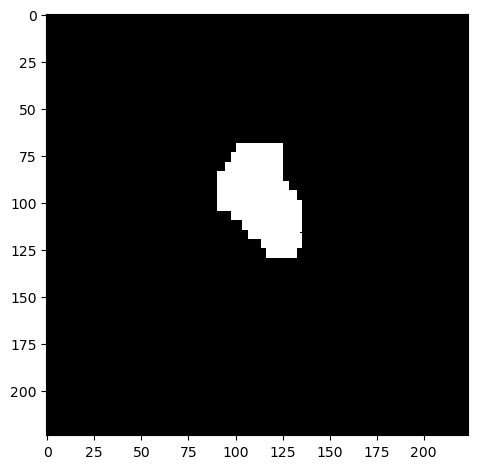

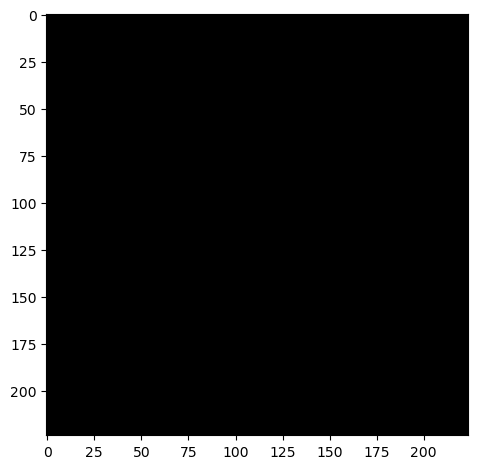

In [33]:
x = random.randint(0, len(preds_test_t))

print("Image number: ",x)
imshow(X_test[x])
plt.show()
imshow(np.squeeze(Y_test[x]))
plt.show()
imshow(np.squeeze(preds_test_t[x]))
plt.show()

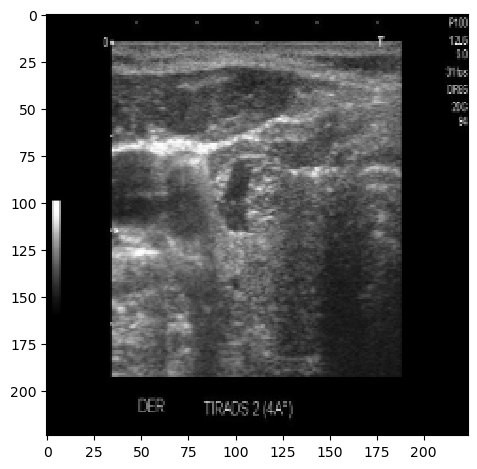

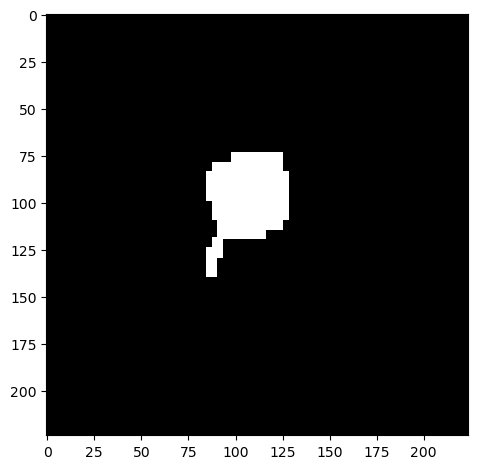

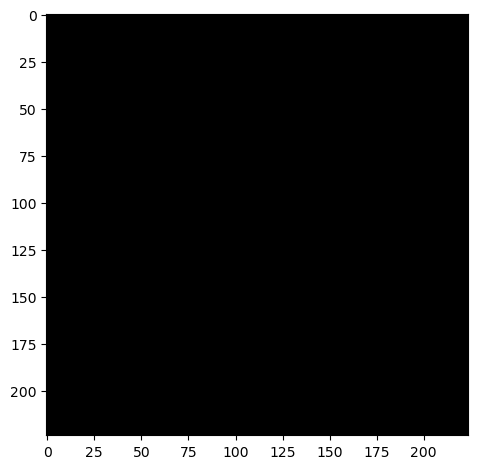

Image number:  384_1


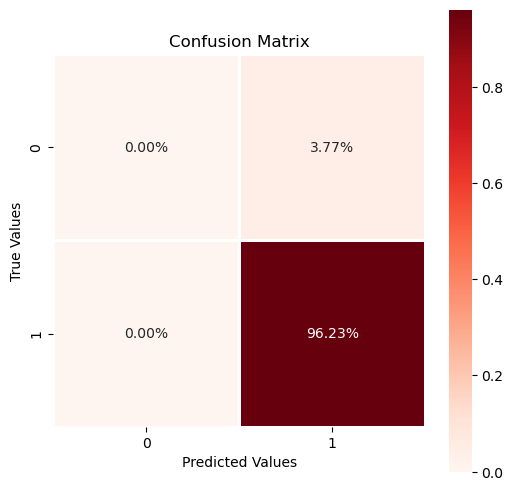

True positive:  0
False positive:  0
False negative:  1890
True negative:  48286


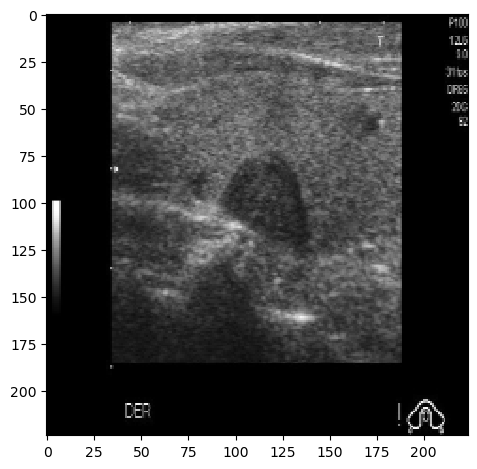

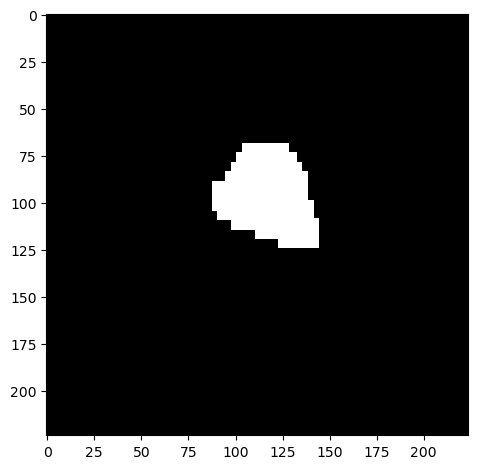

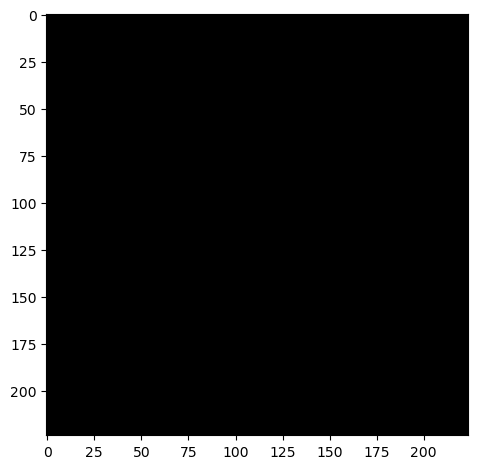

Image number:  363_1


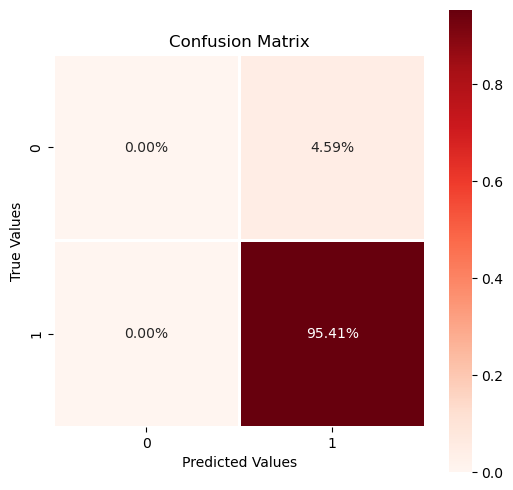

True positive:  0
False positive:  0
False negative:  2302
True negative:  47874


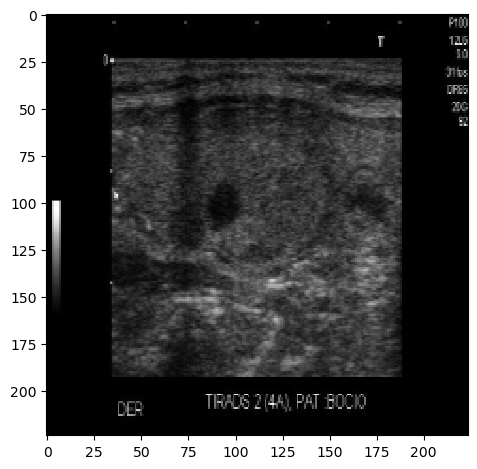

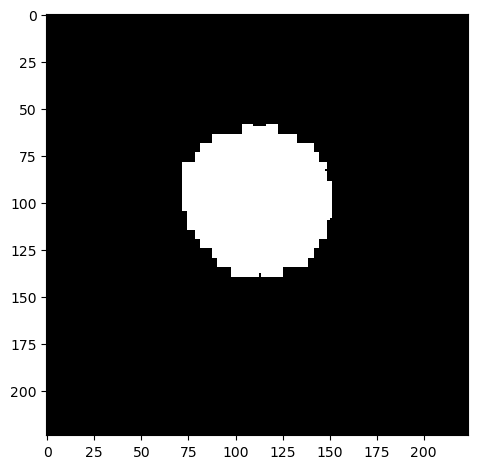

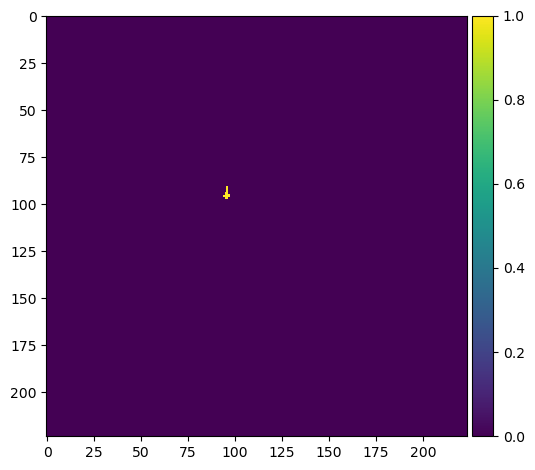

Image number:  369_1


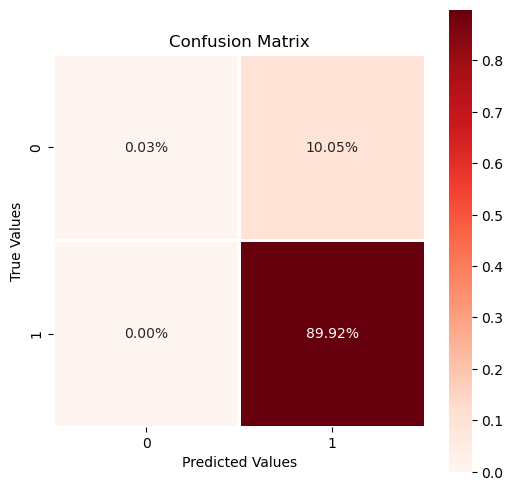

True positive:  14
False positive:  0
False negative:  5045
True negative:  45117


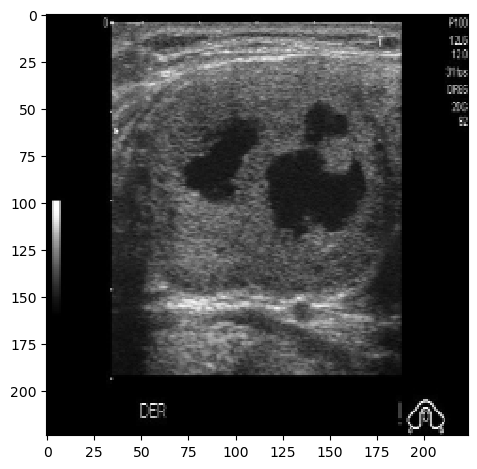

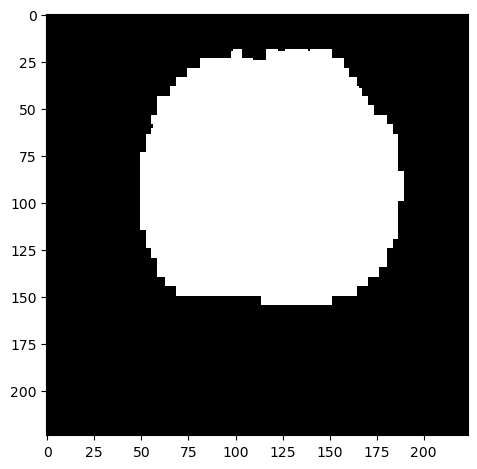

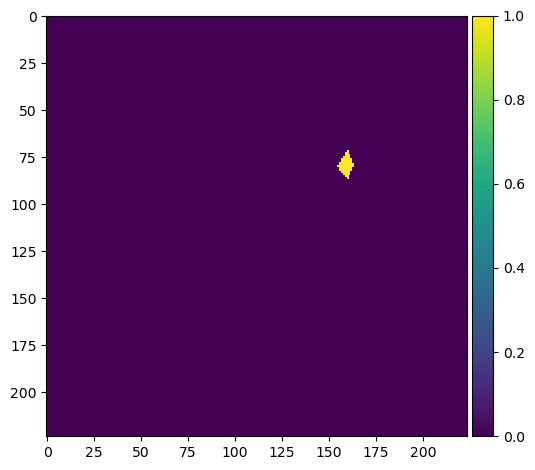

Image number:  380_1


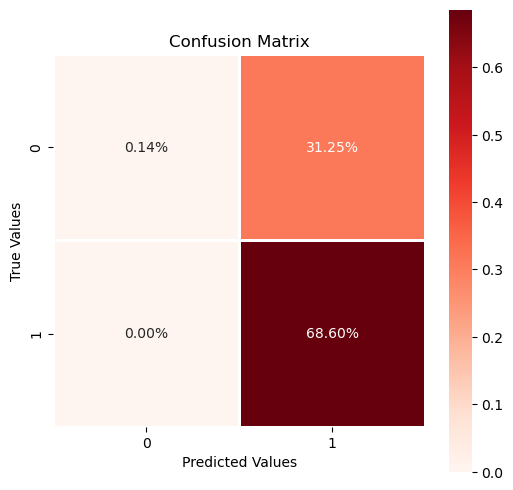

True positive:  72
False positive:  0
False negative:  15681
True negative:  34423


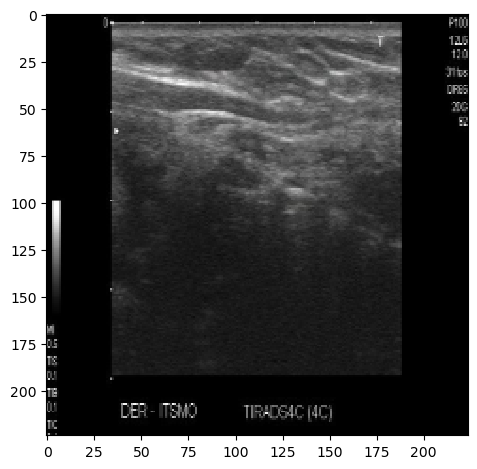

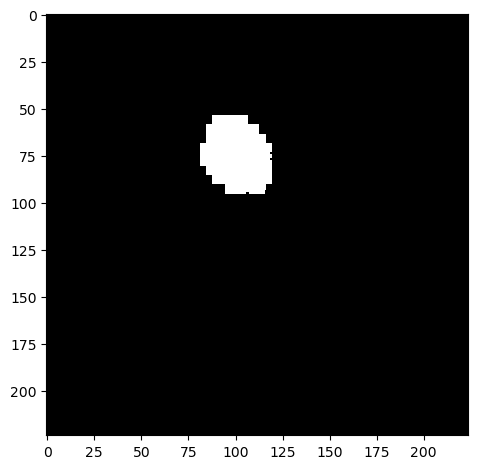

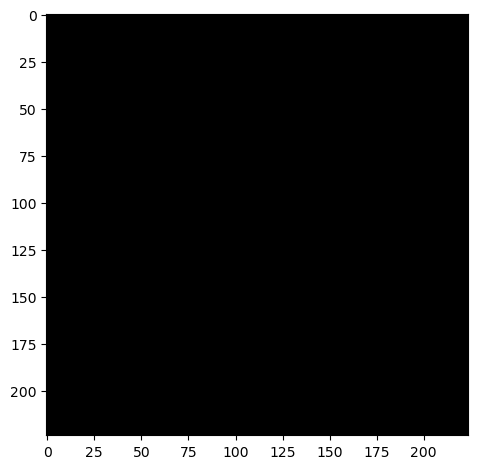

Image number:  367_1


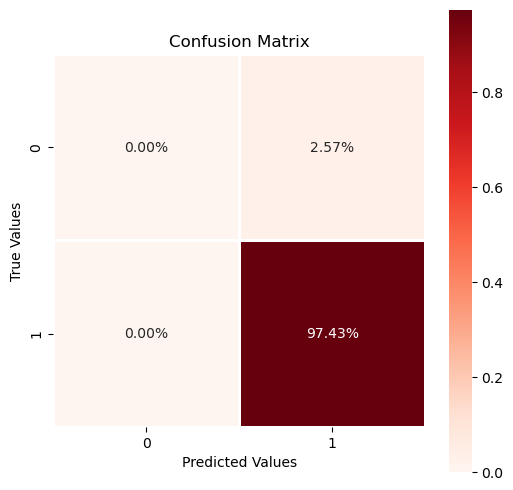

True positive:  0
False positive:  0
False negative:  1290
True negative:  48886


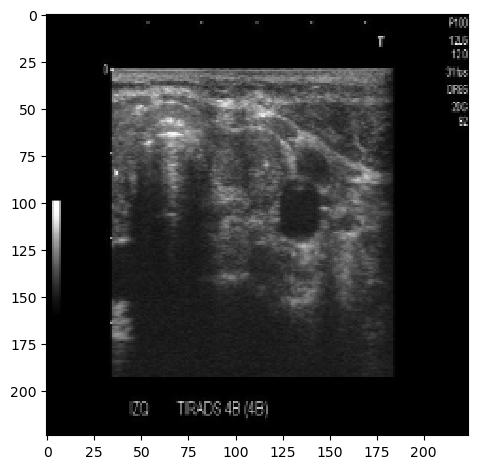

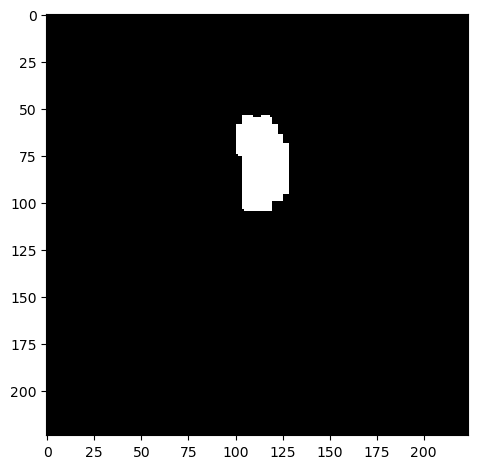

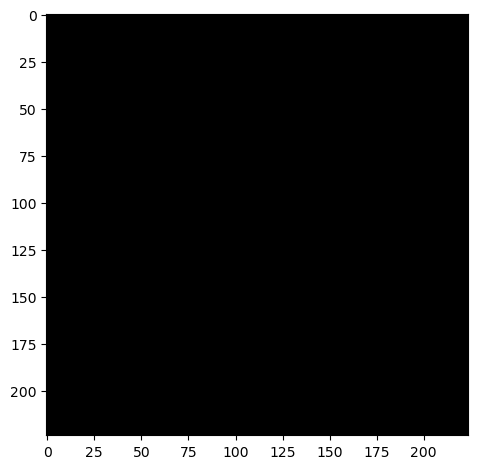

Image number:  390_1


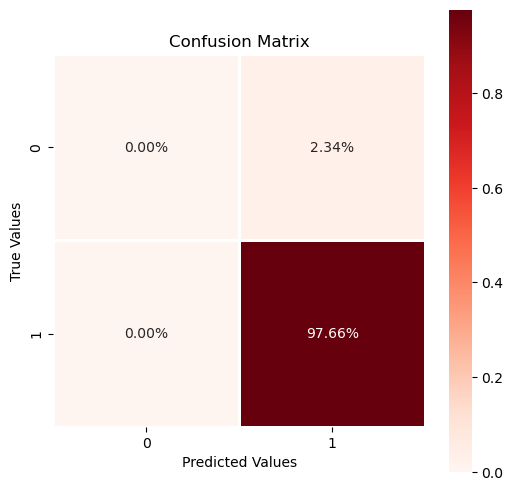

True positive:  0
False positive:  0
False negative:  1172
True negative:  49004


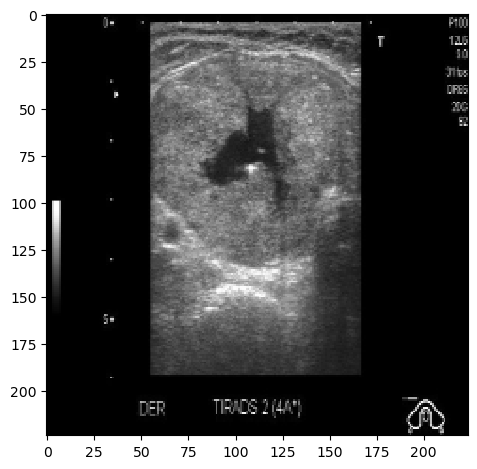

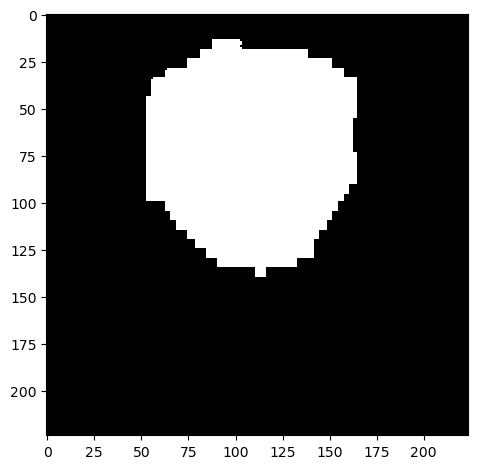

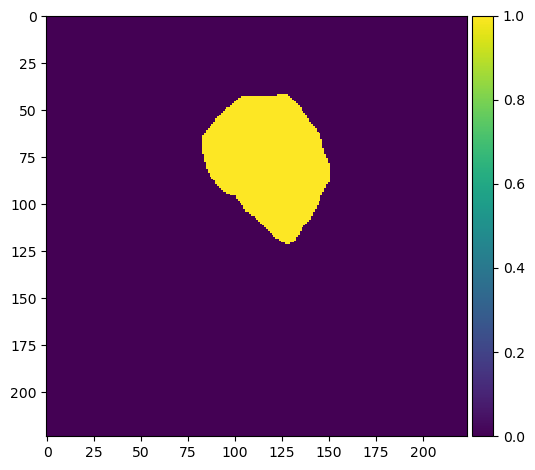

Image number:  377_1


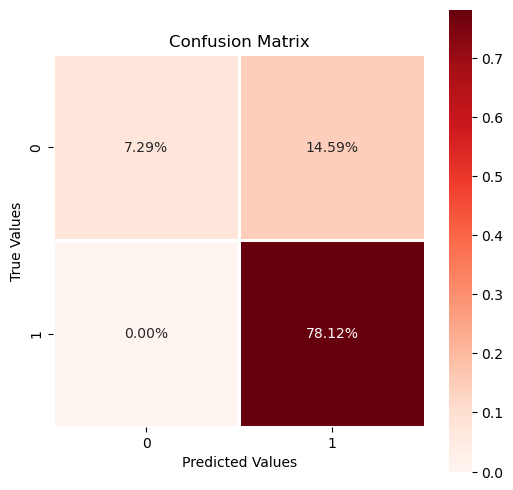

True positive:  3658
False positive:  0
False negative:  7321
True negative:  39197


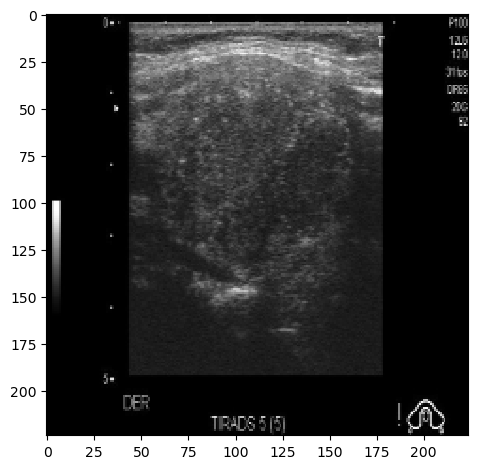

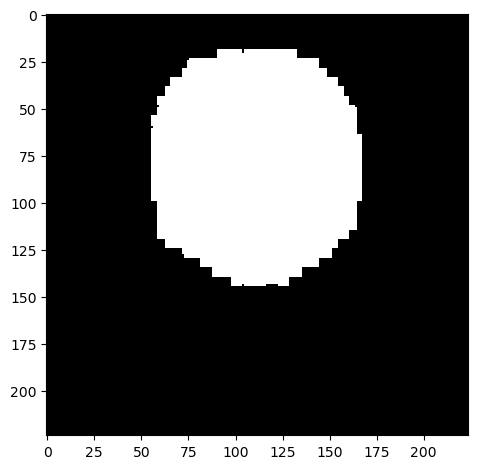

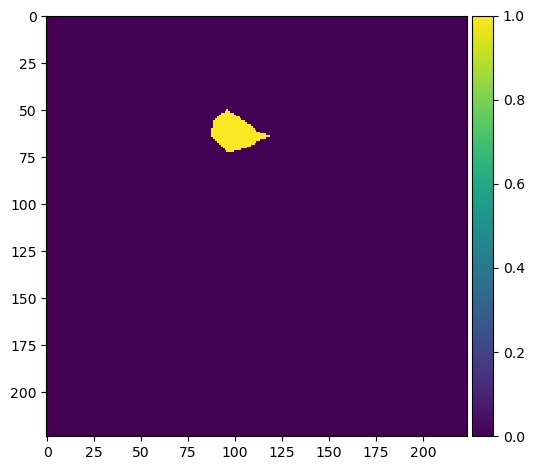

Image number:  394_1


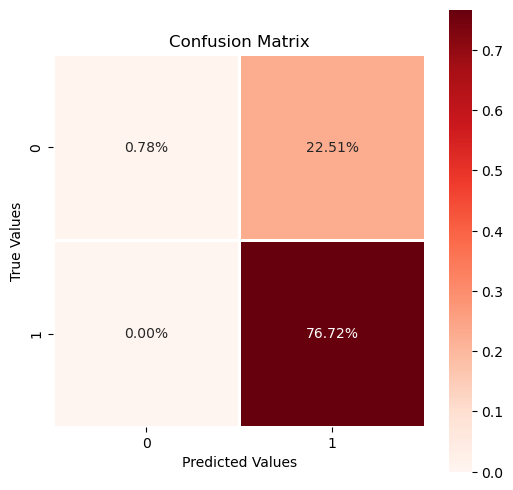

True positive:  389
False positive:  0
False negative:  11293
True negative:  38494


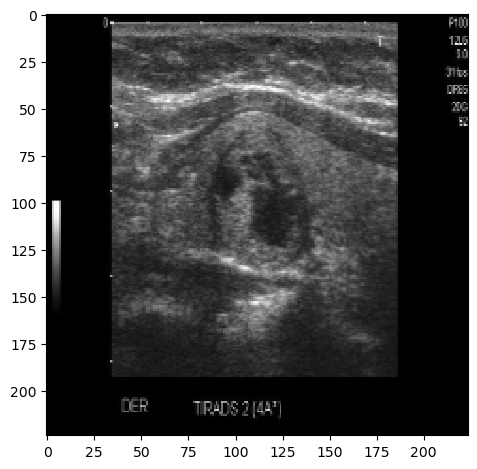

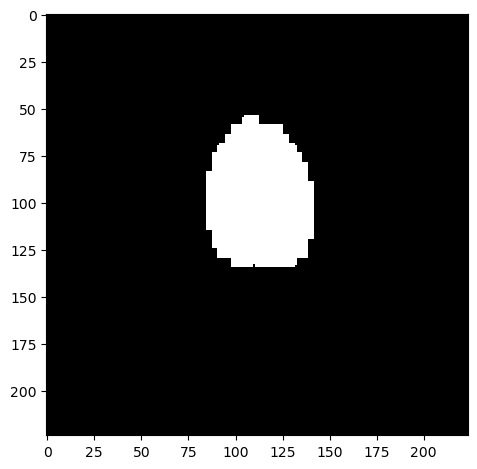

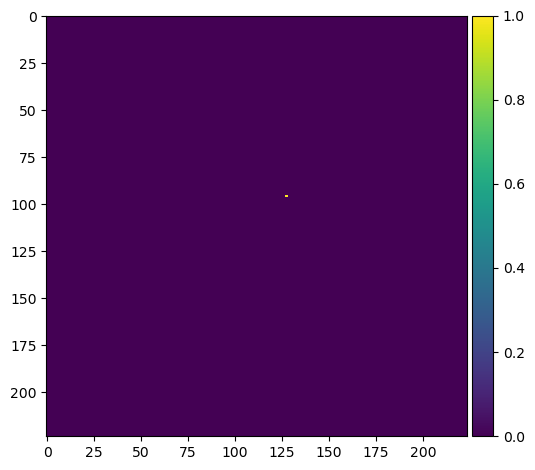

Image number:  373_1


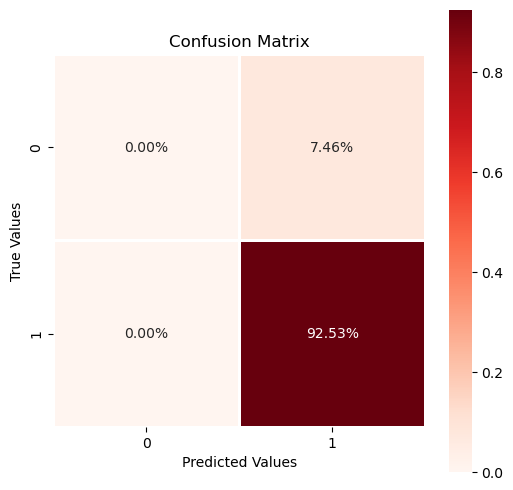

True positive:  2
False positive:  0
False negative:  3744
True negative:  46430


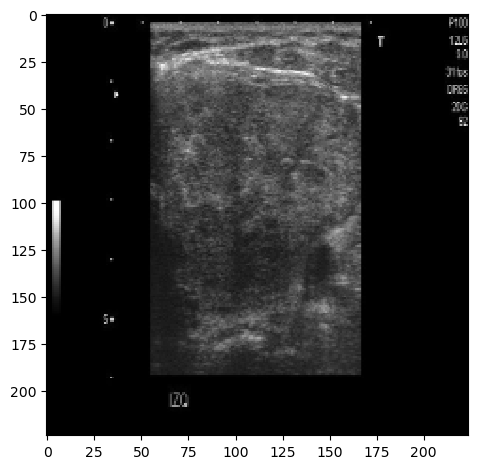

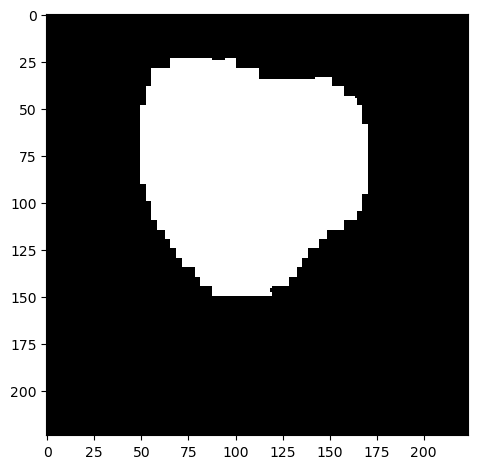

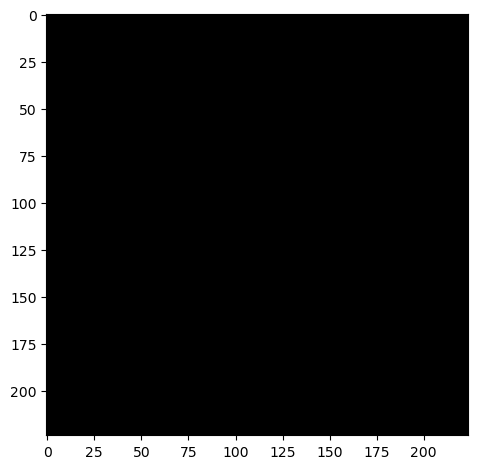

Image number:  379_1


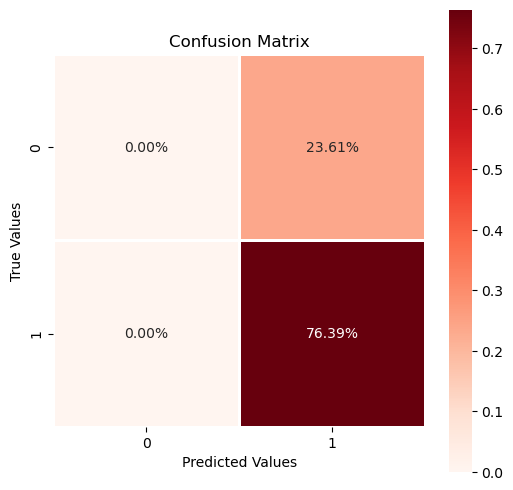

True positive:  0
False positive:  0
False negative:  11847
True negative:  38329


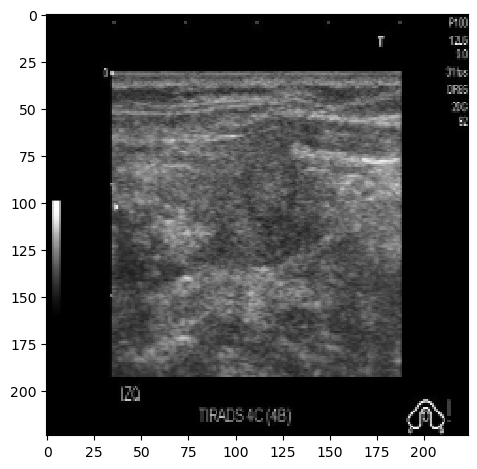

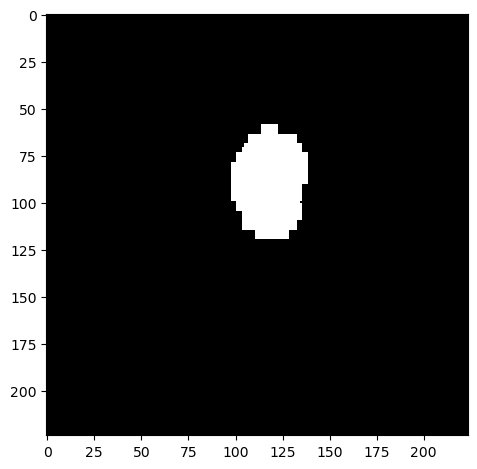

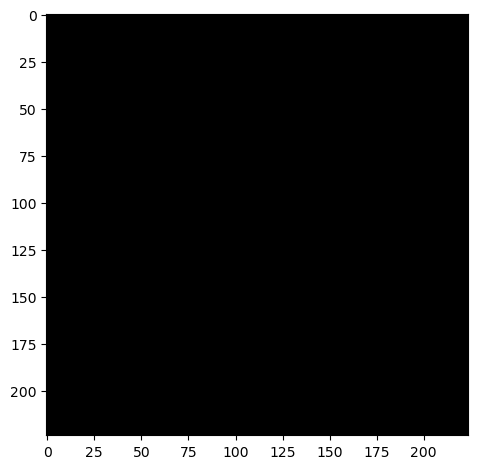

Image number:  371_2


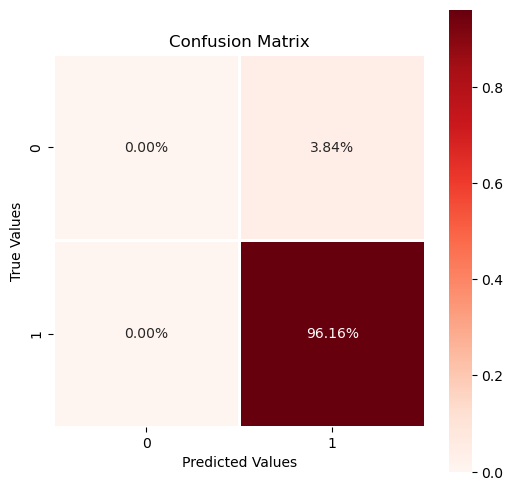

True positive:  0
False positive:  0
False negative:  1926
True negative:  48250


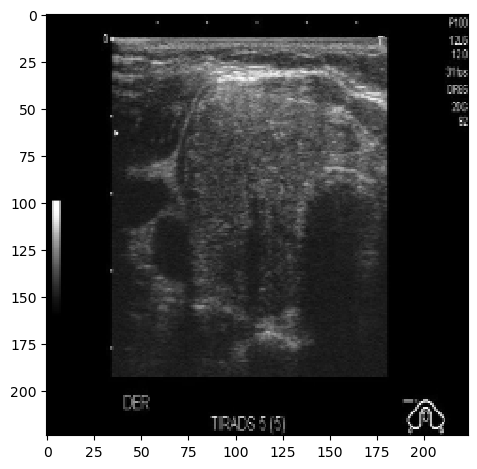

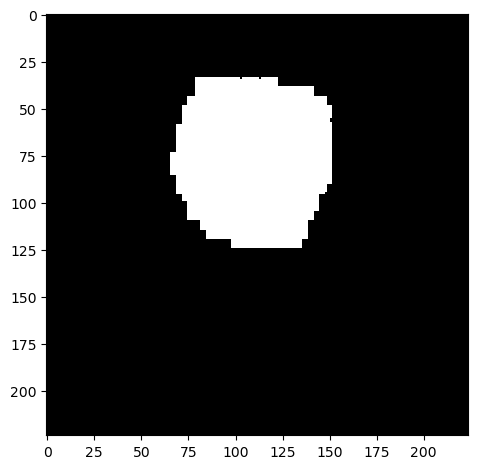

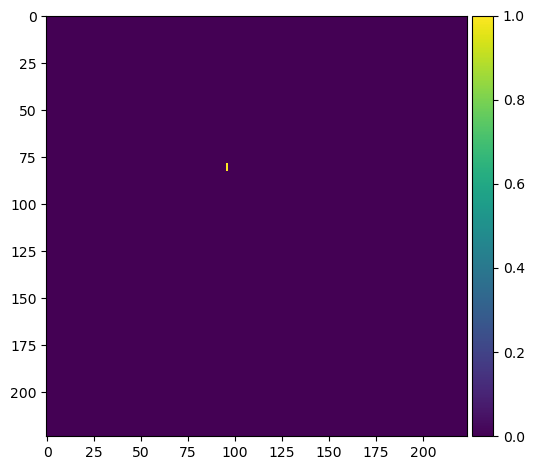

Image number:  366_3


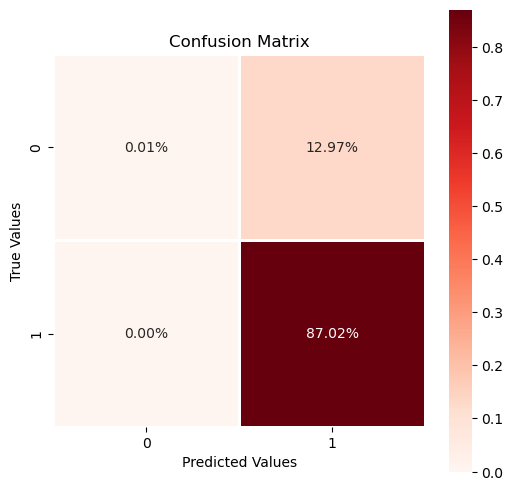

True positive:  4
False positive:  0
False negative:  6510
True negative:  43662


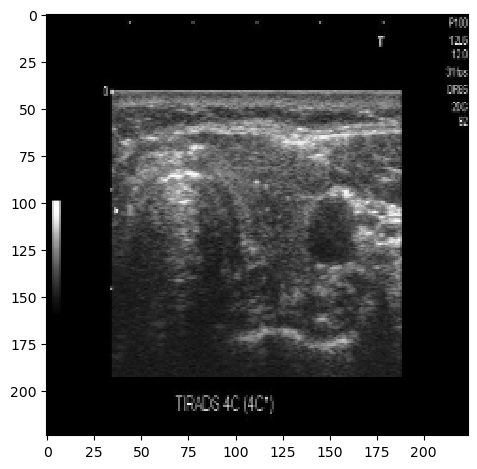

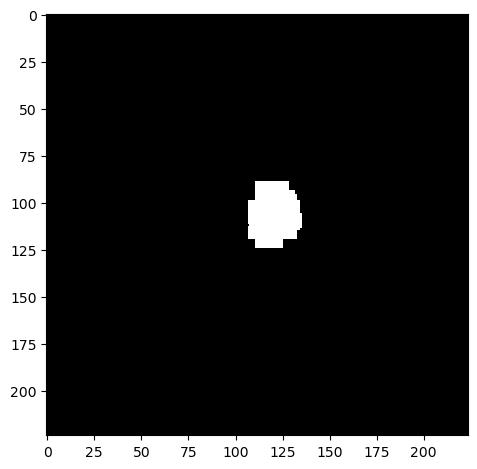

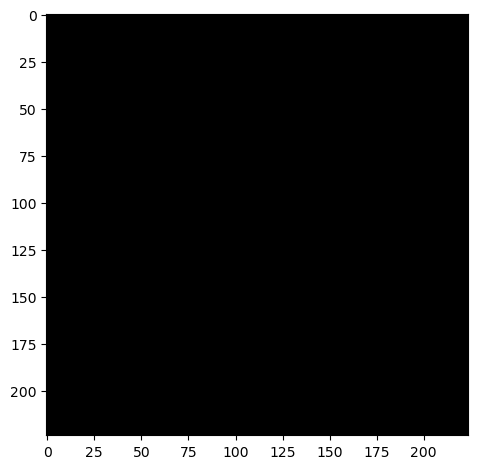

Image number:  387_1


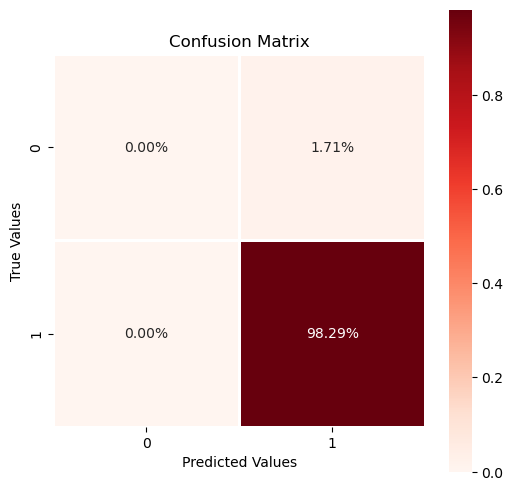

True positive:  0
False positive:  0
False negative:  858
True negative:  49318


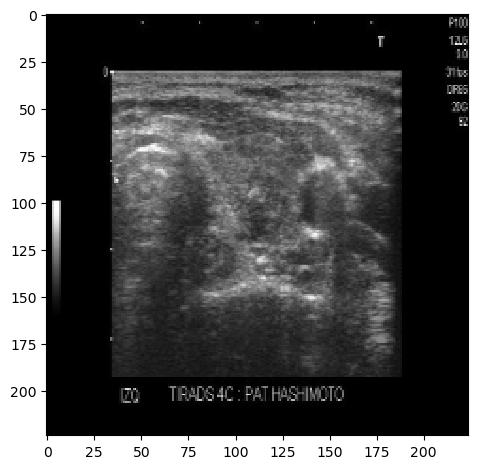

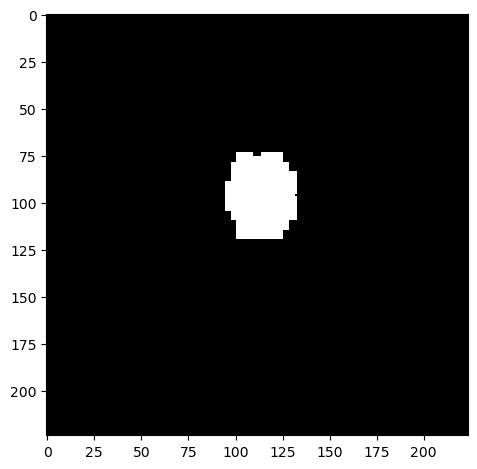

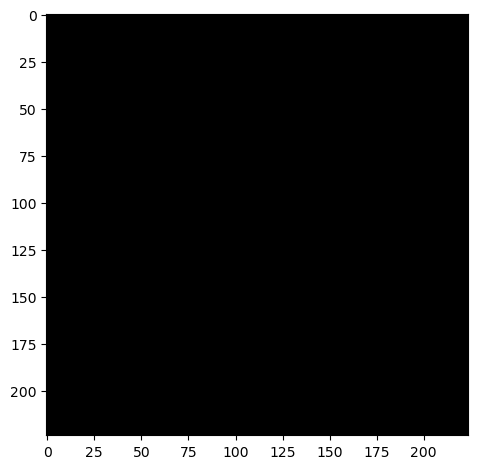

Image number:  381_2


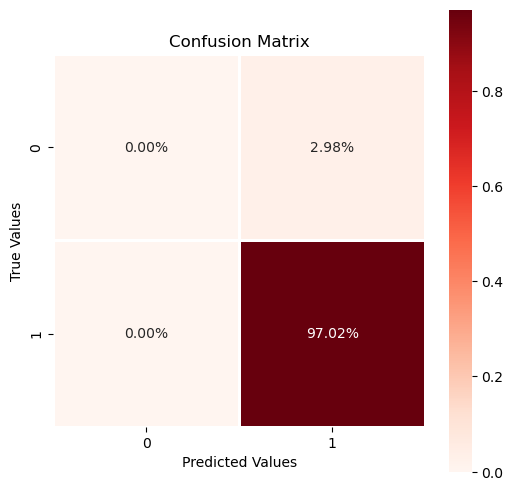

True positive:  0
False positive:  0
False negative:  1494
True negative:  48682


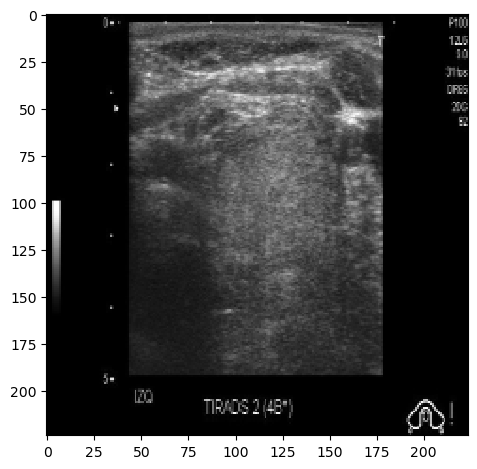

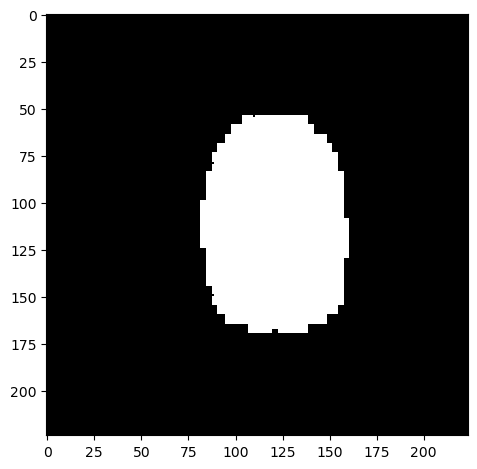

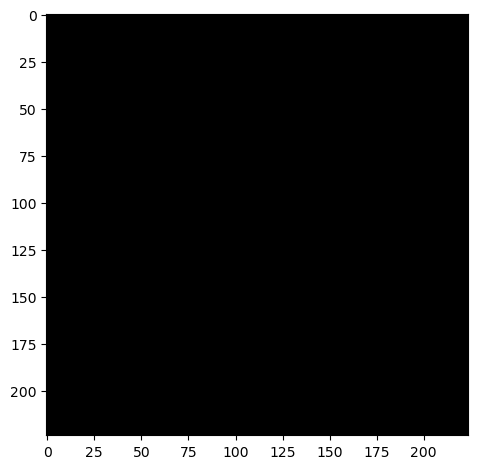

Image number:  366_2


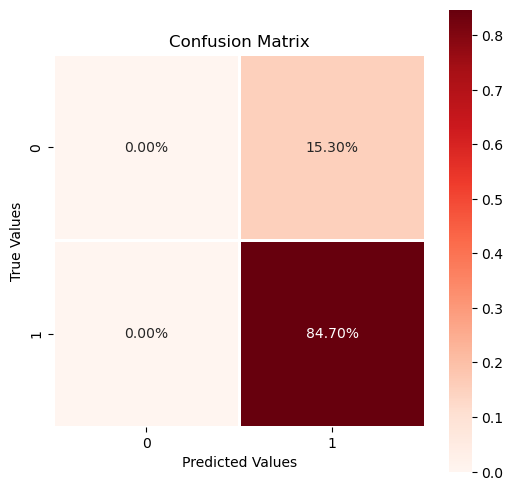

True positive:  0
False positive:  0
False negative:  7675
True negative:  42501


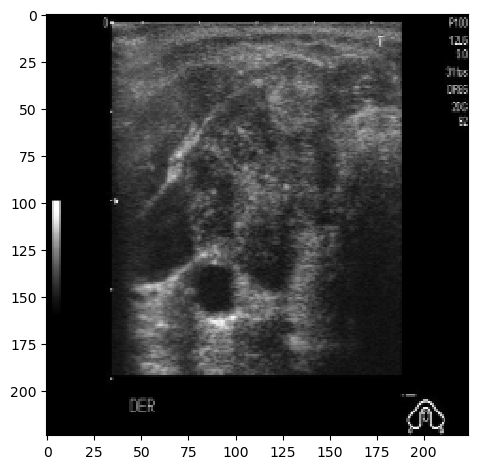

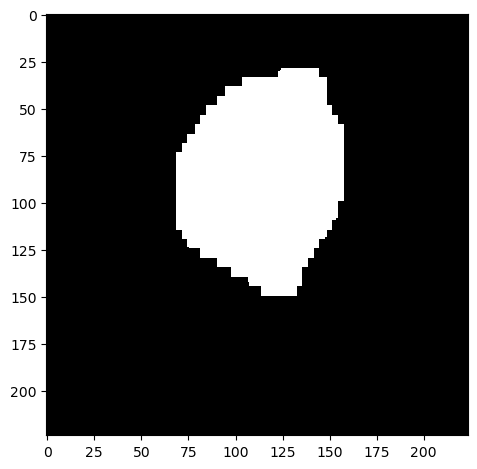

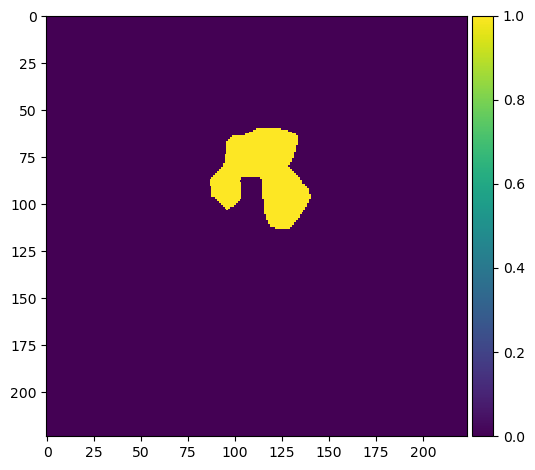

Image number:  383_1


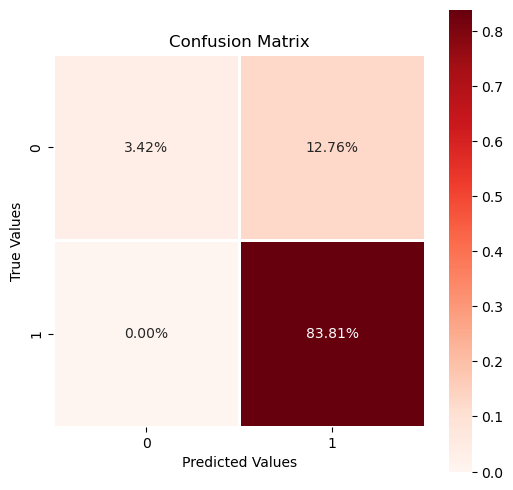

True positive:  1717
False positive:  0
False negative:  6404
True negative:  42055


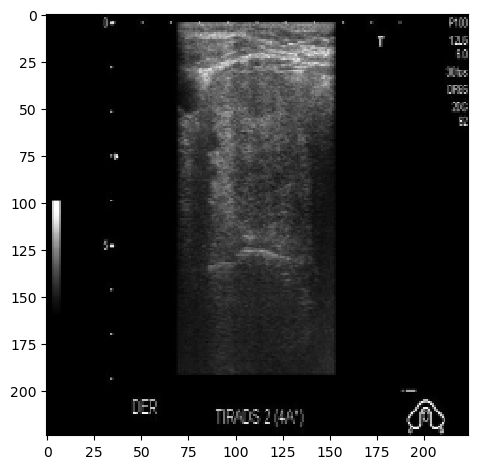

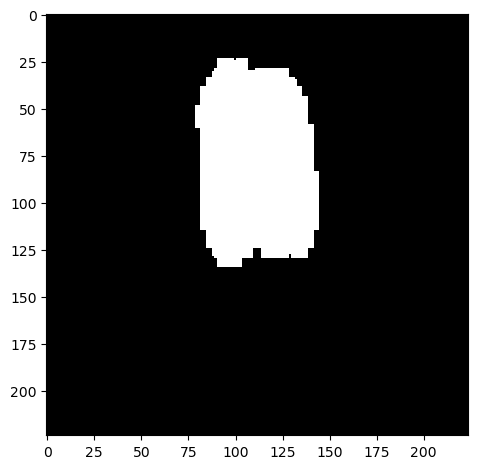

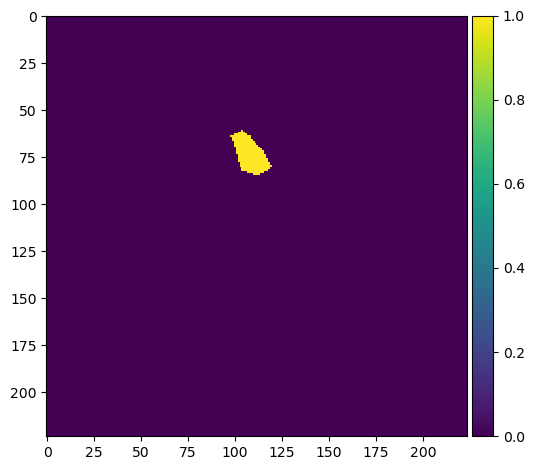

Image number:  364_1


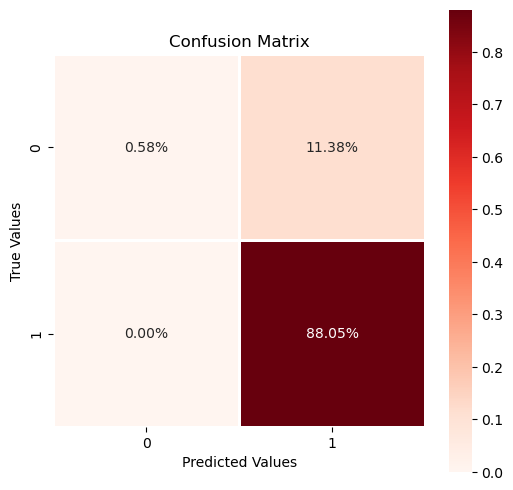

True positive:  290
False positive:  0
False negative:  5708
True negative:  44178


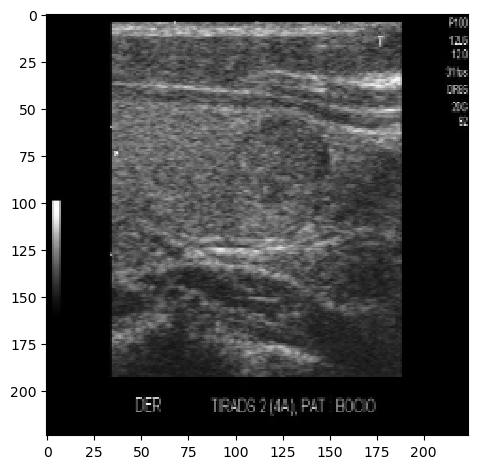

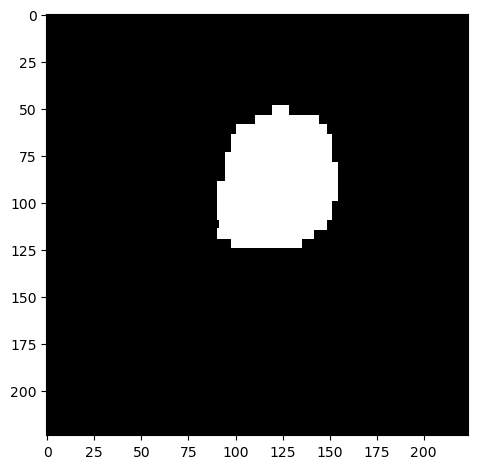

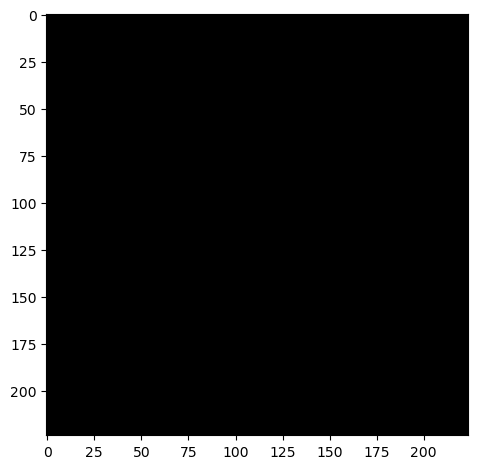

Image number:  391_2


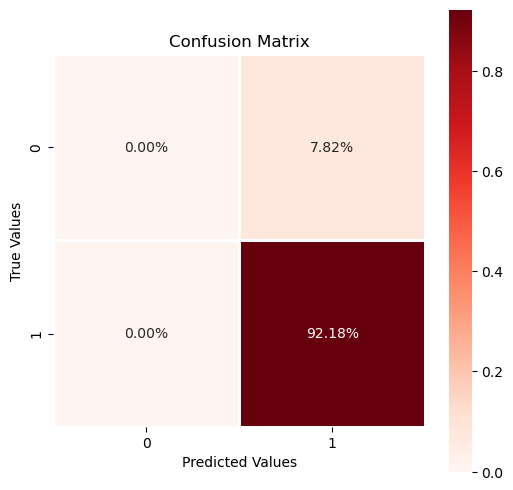

True positive:  0
False positive:  0
False negative:  3925
True negative:  46251


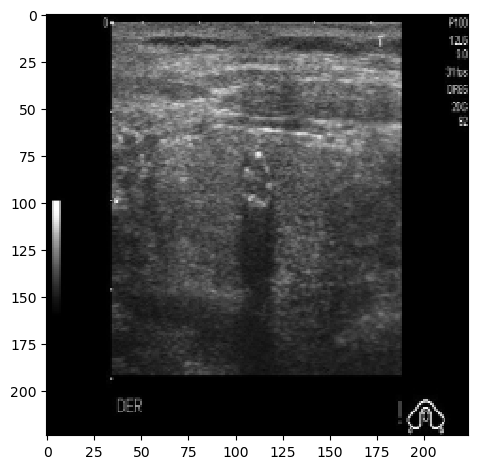

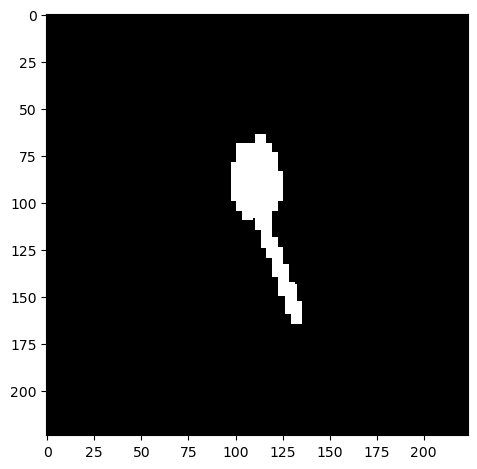

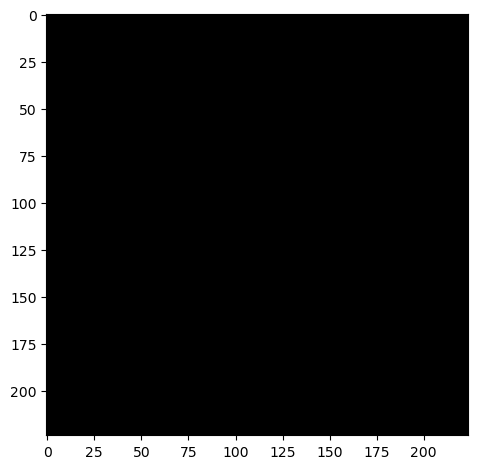

Image number:  399_1


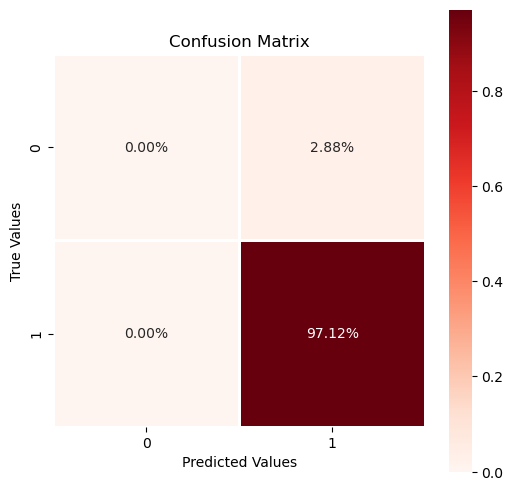

True positive:  0
False positive:  0
False negative:  1447
True negative:  48729


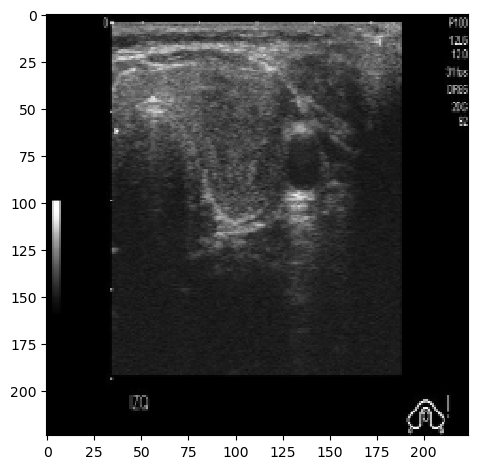

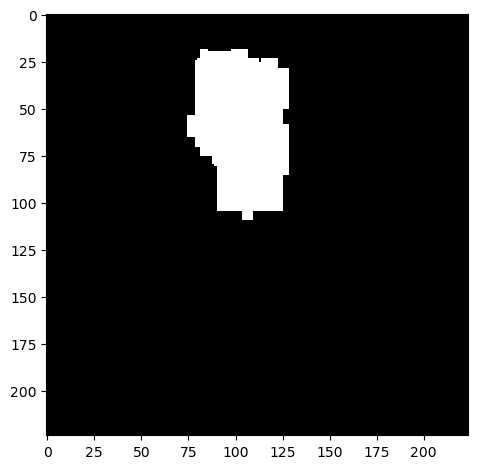

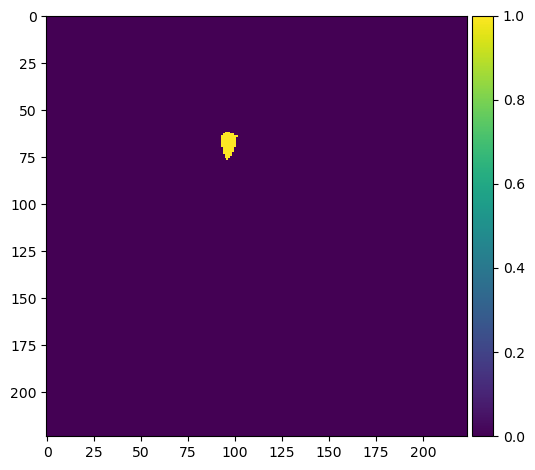

Image number:  374_1


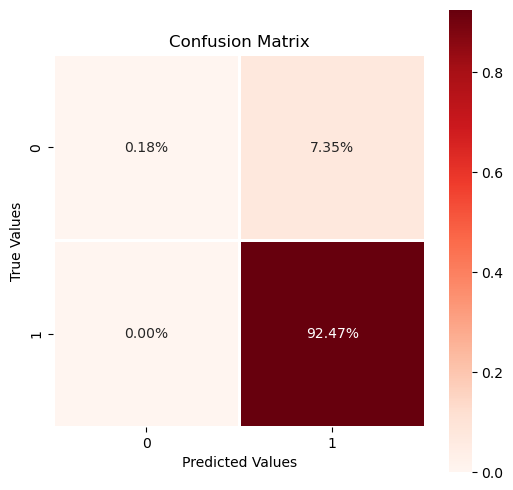

True positive:  89
False positive:  0
False negative:  3689
True negative:  46398


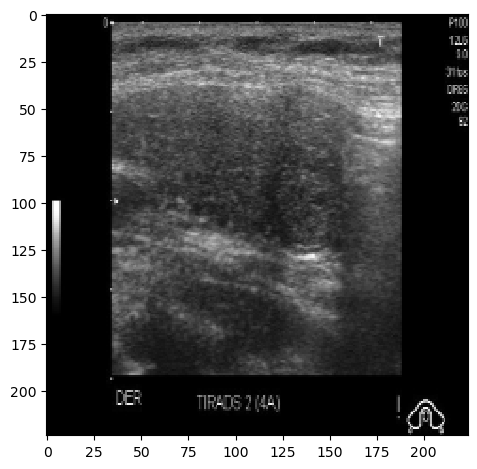

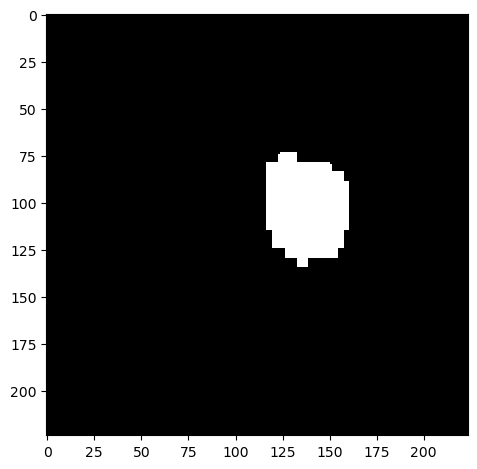

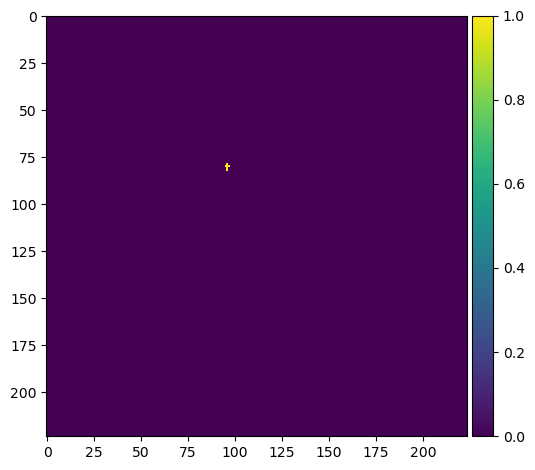

Image number:  397_1


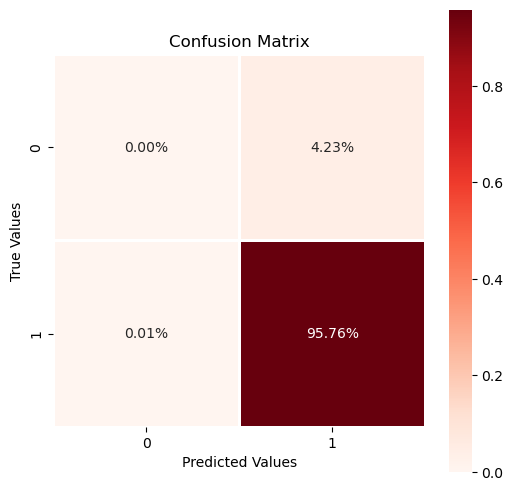

True positive:  0
False positive:  6
False negative:  2122
True negative:  48048


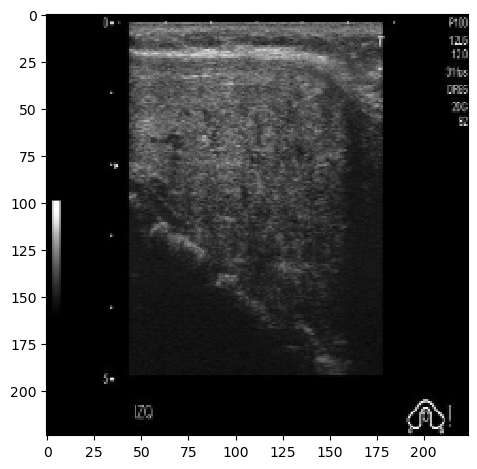

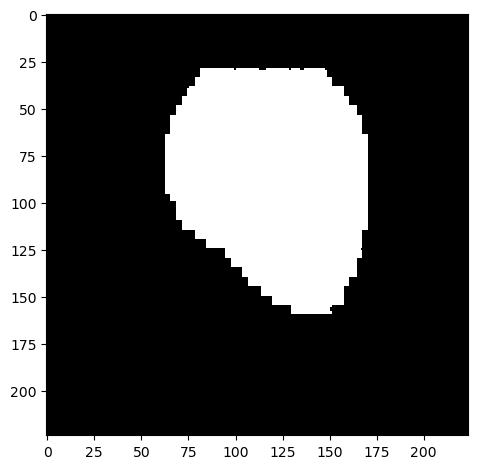

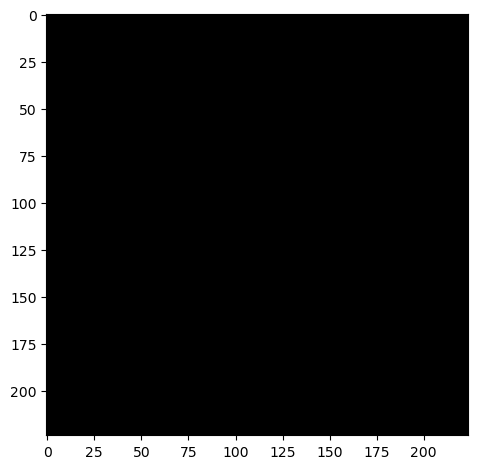

Image number:  370_1


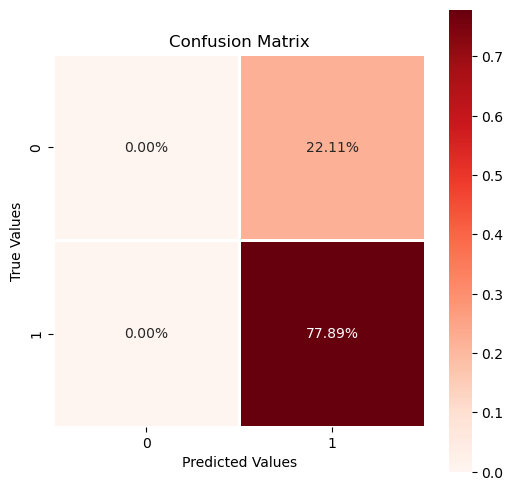

True positive:  0
False positive:  0
False negative:  11093
True negative:  39083


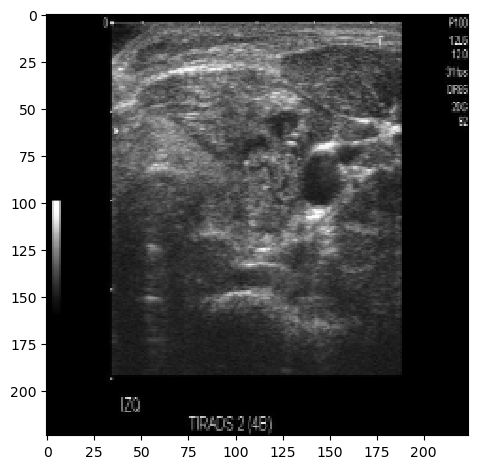

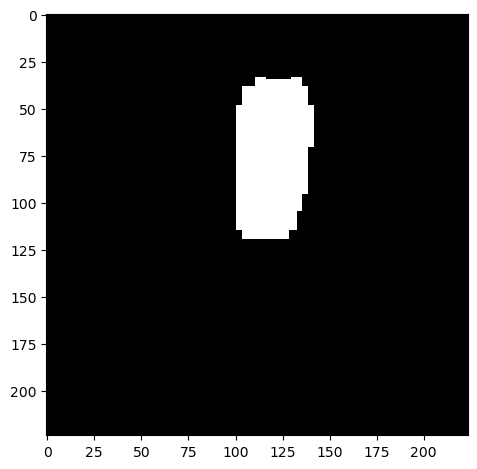

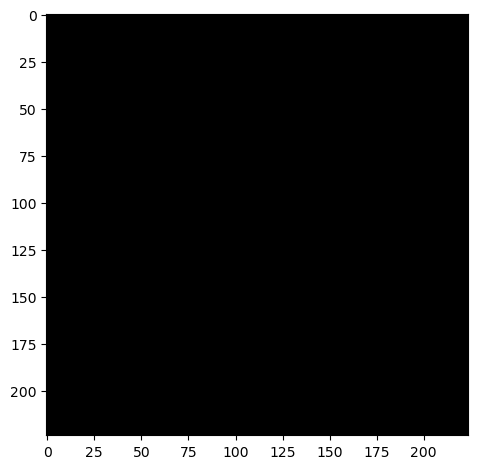

Image number:  395_2


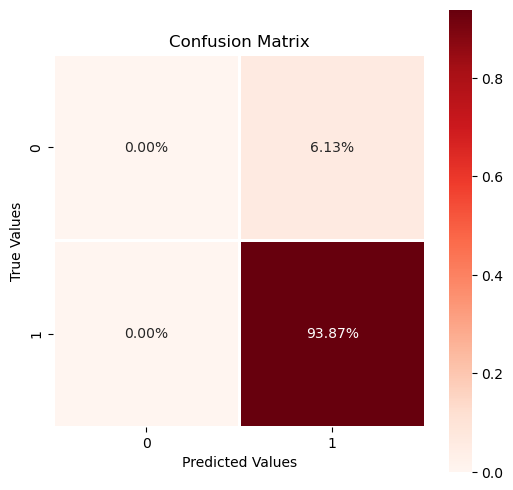

True positive:  0
False positive:  0
False negative:  3074
True negative:  47102


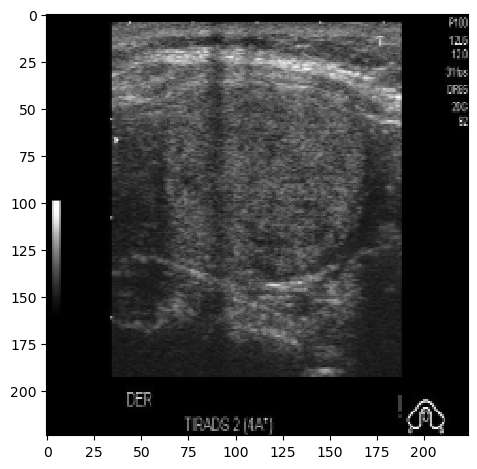

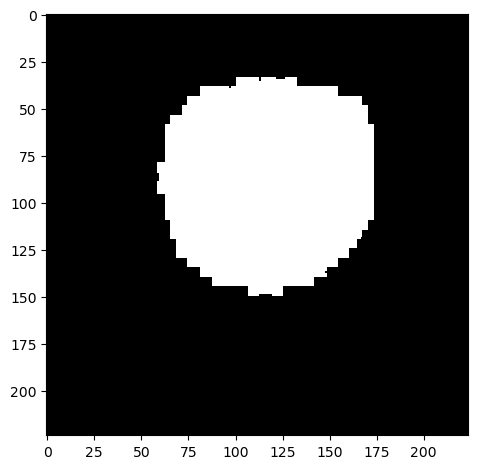

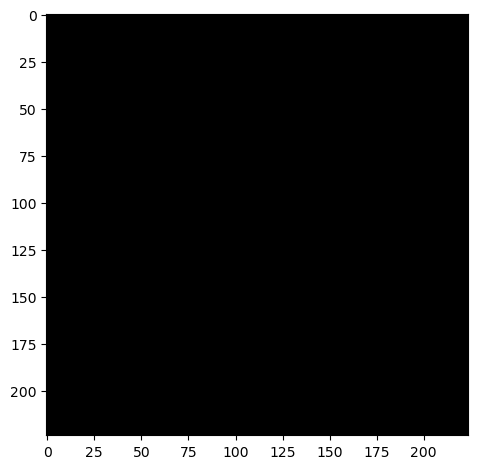

Image number:  361_1


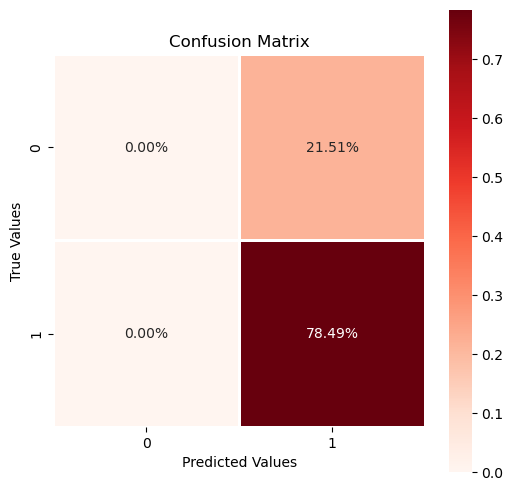

True positive:  0
False positive:  0
False negative:  10793
True negative:  39383


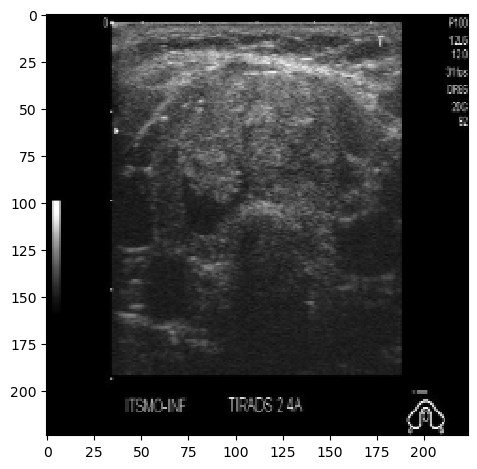

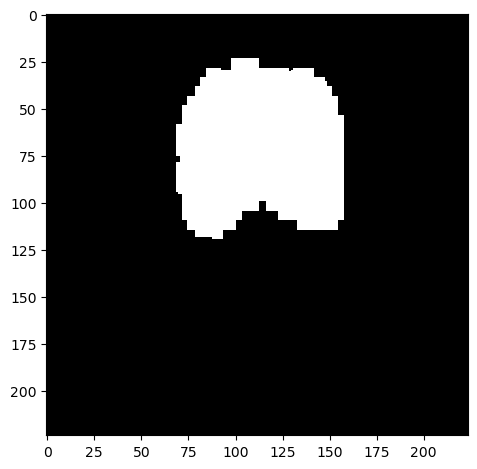

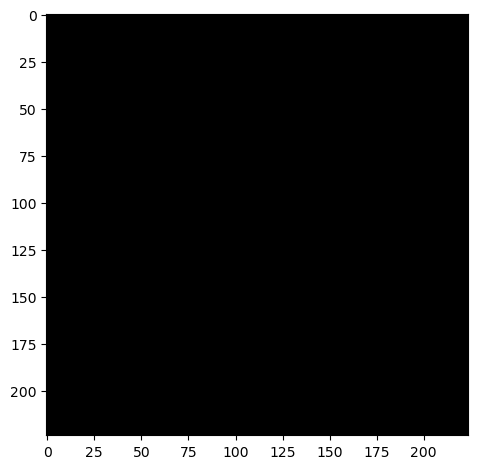

Image number:  386_1


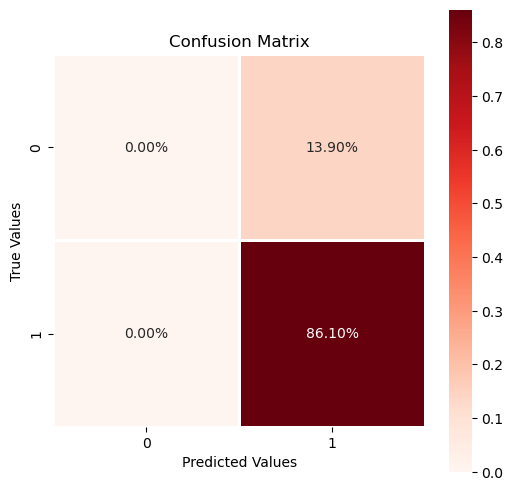

True positive:  0
False positive:  0
False negative:  6976
True negative:  43200


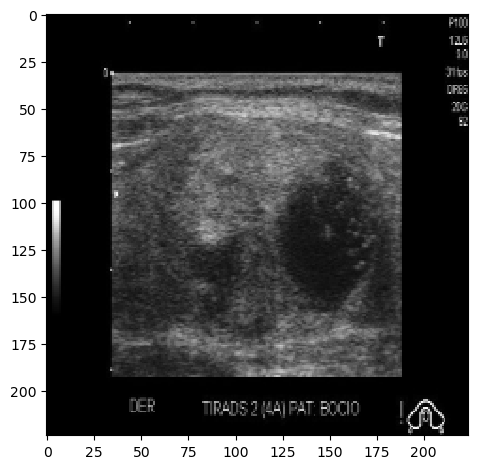

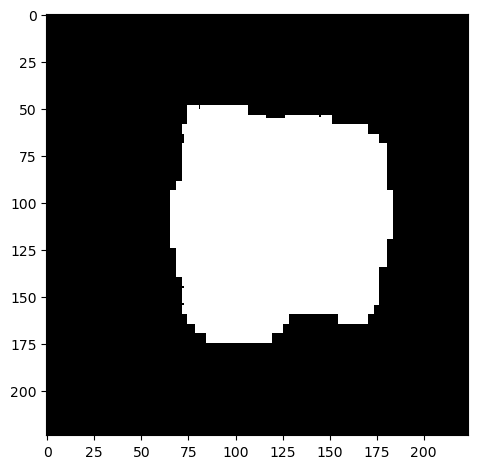

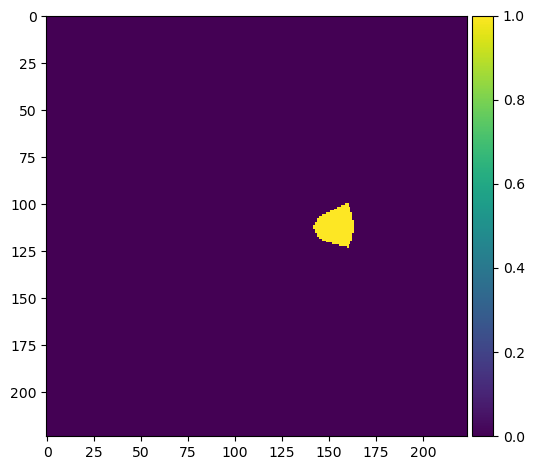

Image number:  365_1


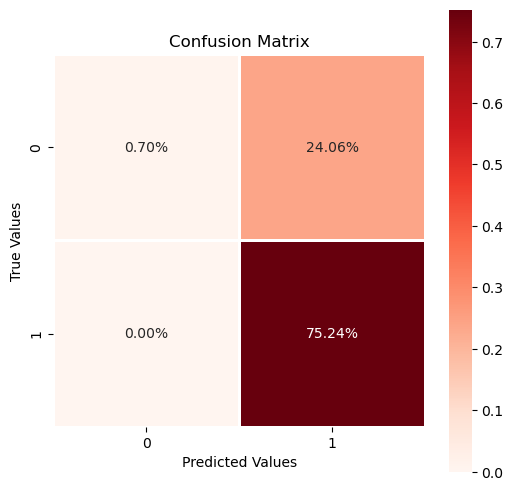

True positive:  349
False positive:  0
False negative:  12074
True negative:  37753


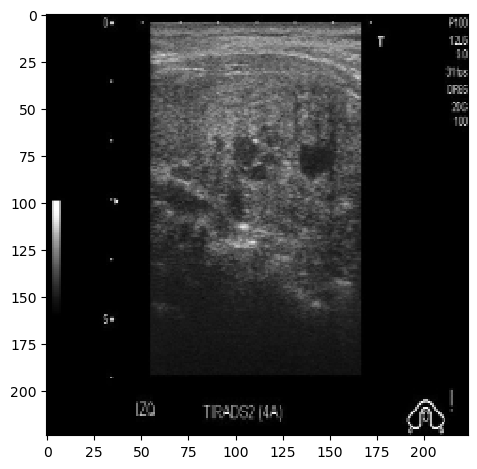

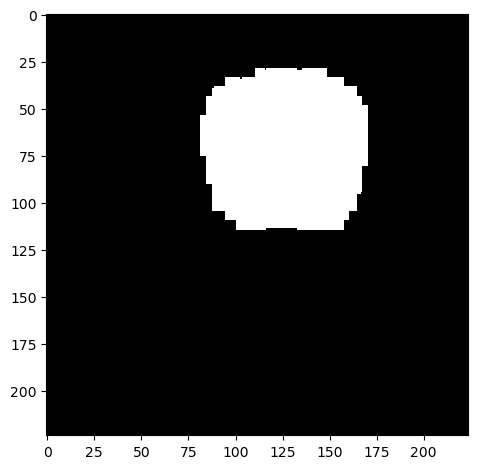

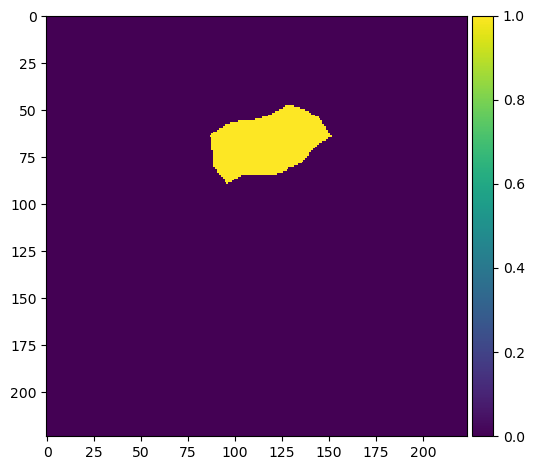

Image number:  382_1


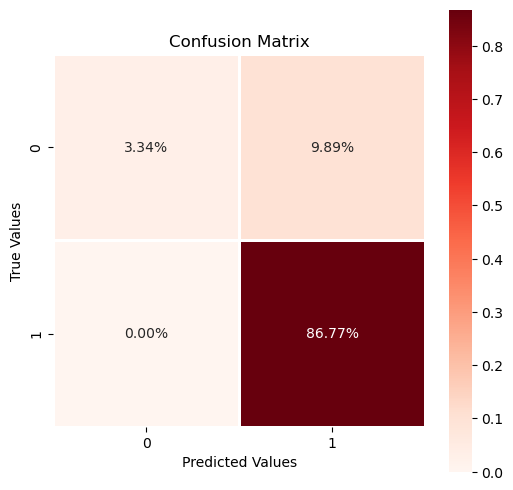

True positive:  1675
False positive:  0
False negative:  4963
True negative:  43538


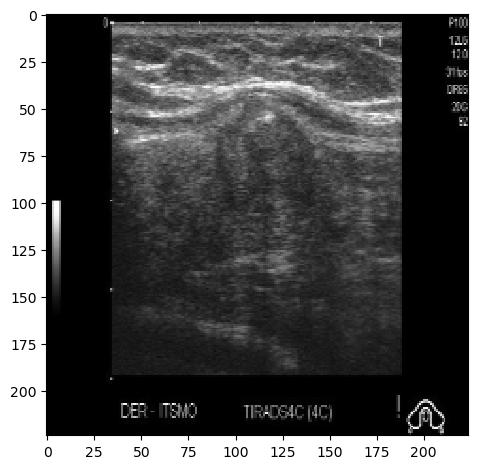

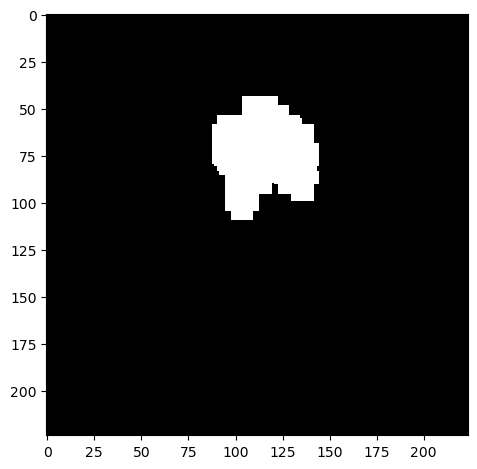

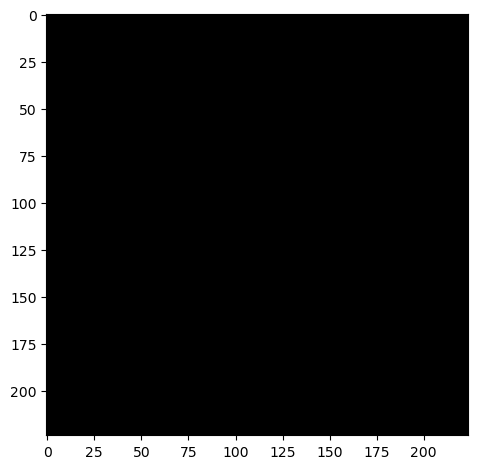

Image number:  367_2


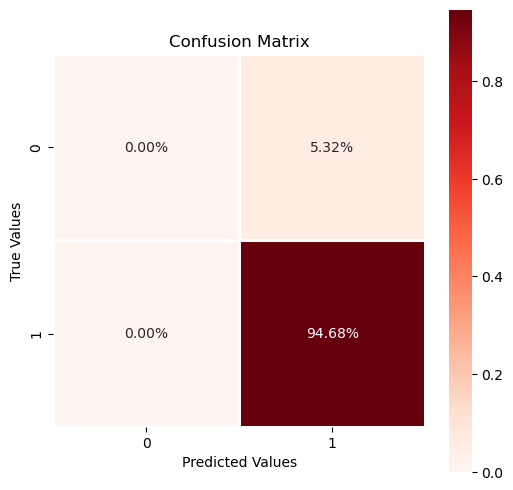

True positive:  0
False positive:  0
False negative:  2670
True negative:  47506


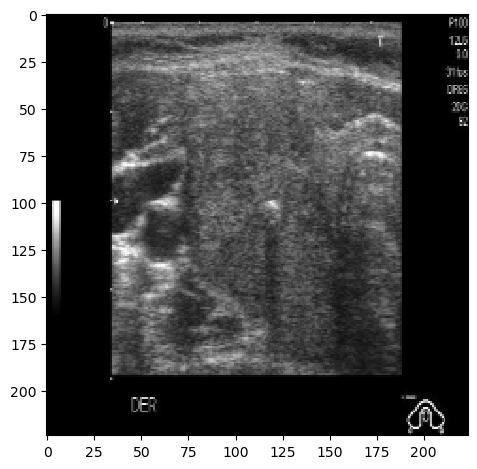

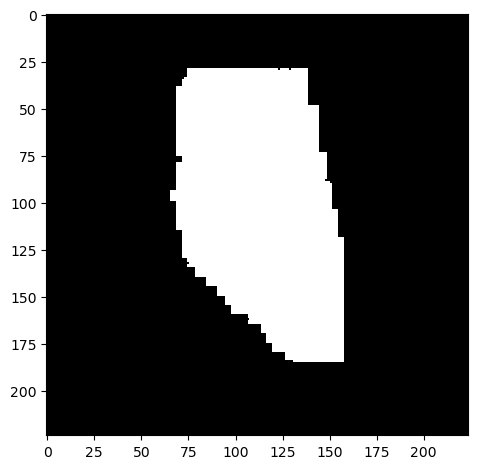

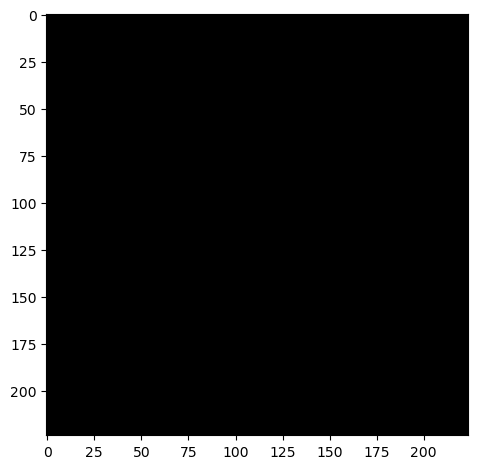

Image number:  388_1


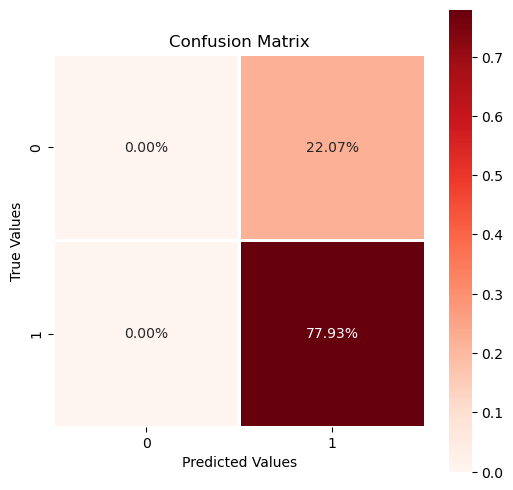

True positive:  0
False positive:  0
False negative:  11072
True negative:  39104


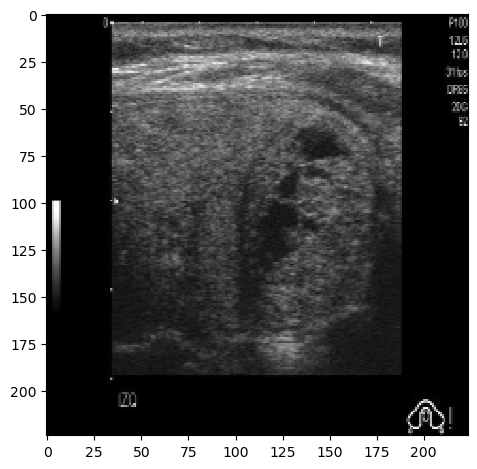

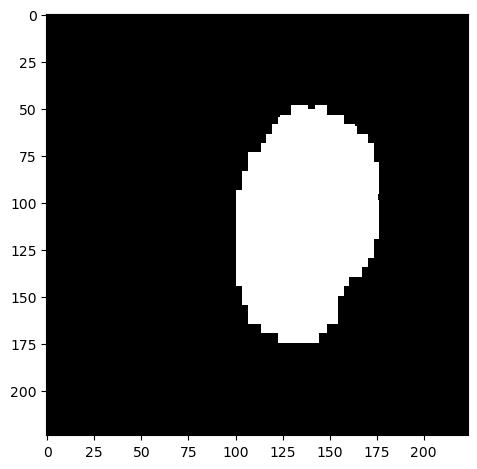

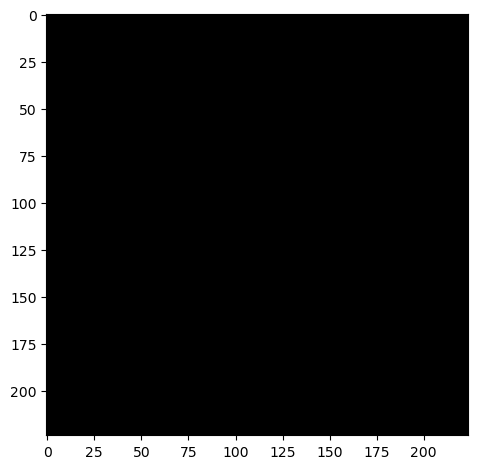

Image number:  375_1


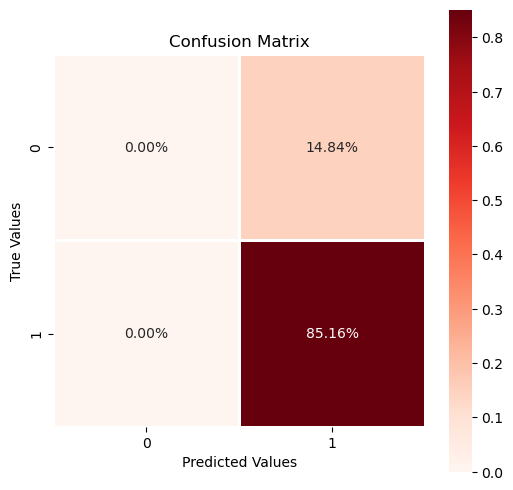

True positive:  0
False positive:  0
False negative:  7448
True negative:  42728


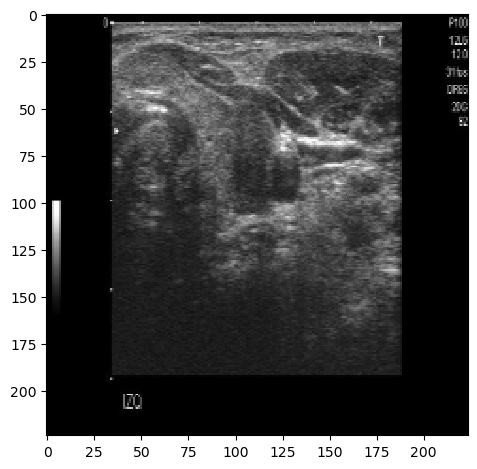

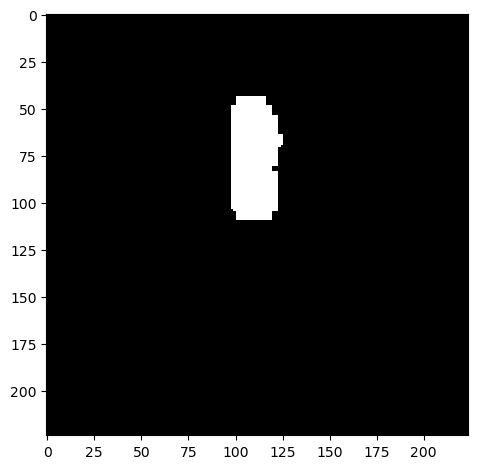

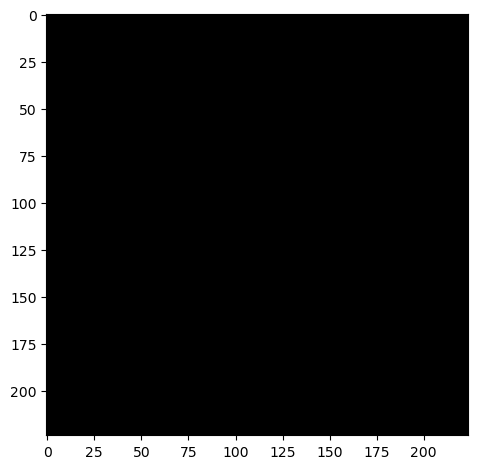

Image number:  392_1


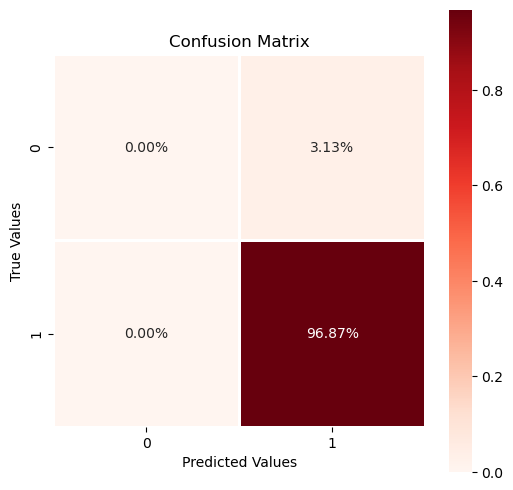

True positive:  0
False positive:  0
False negative:  1570
True negative:  48606


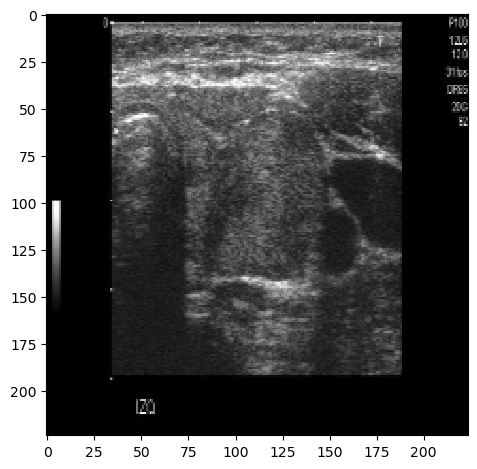

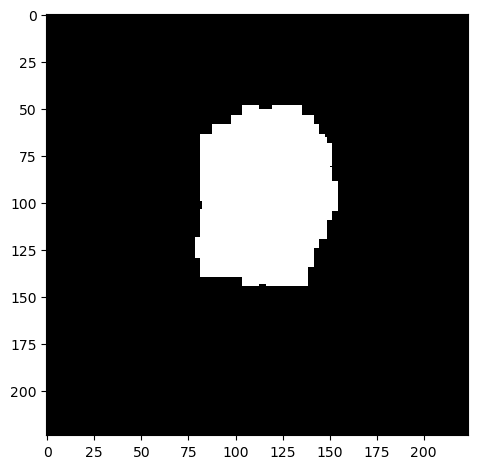

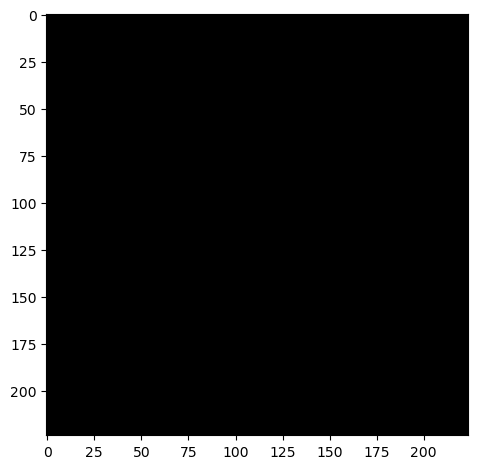

Image number:  400_1


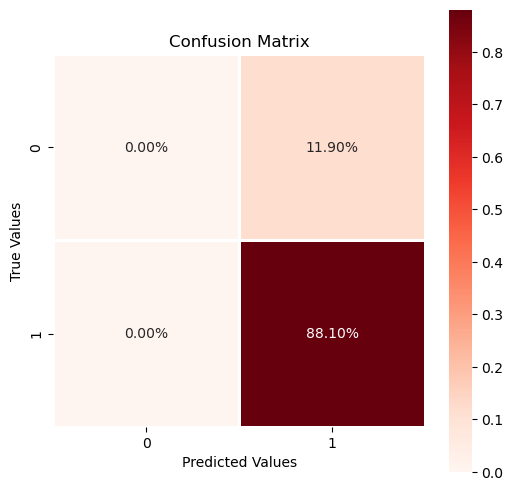

True positive:  0
False positive:  0
False negative:  5971
True negative:  44205


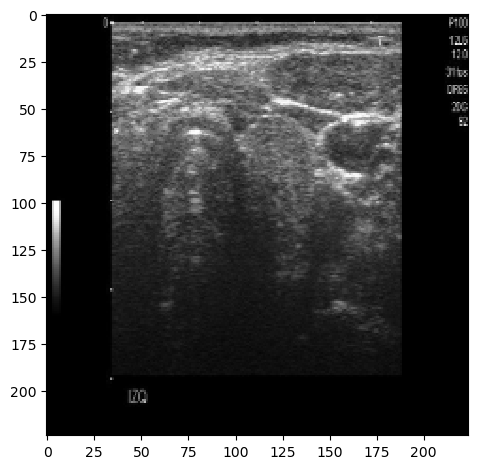

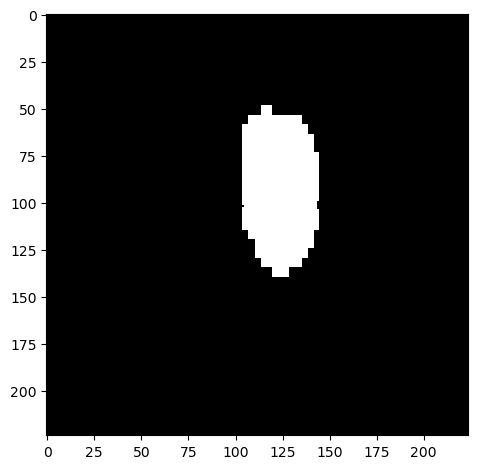

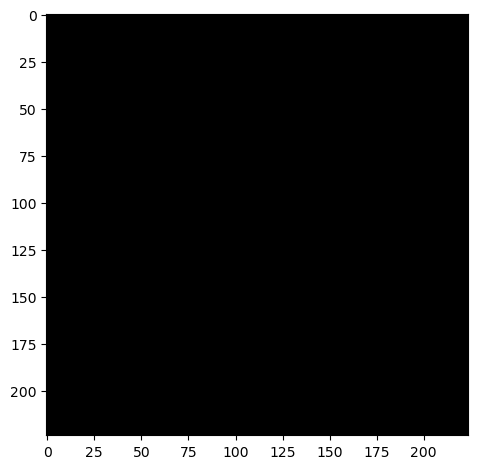

Image number:  398_1


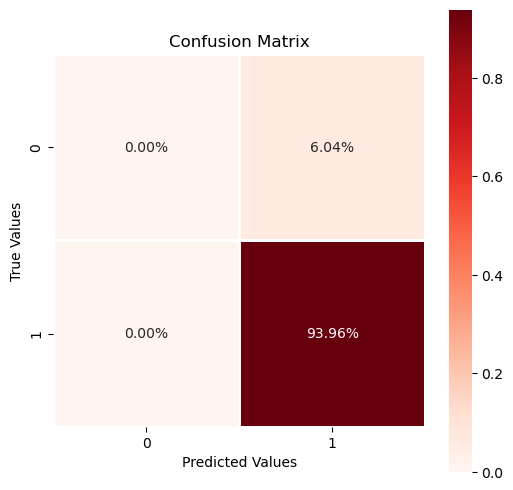

True positive:  0
False positive:  0
False negative:  3031
True negative:  47145


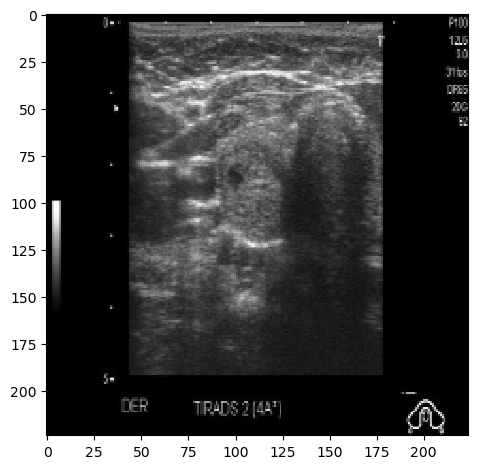

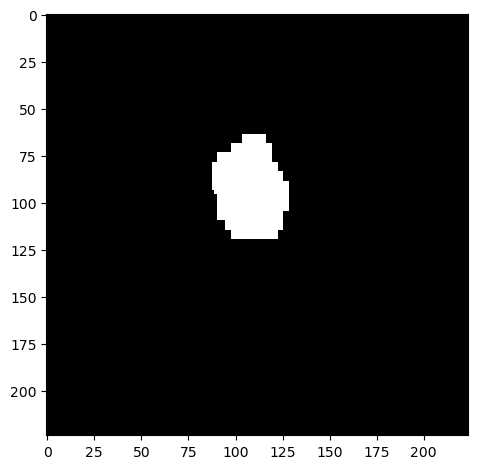

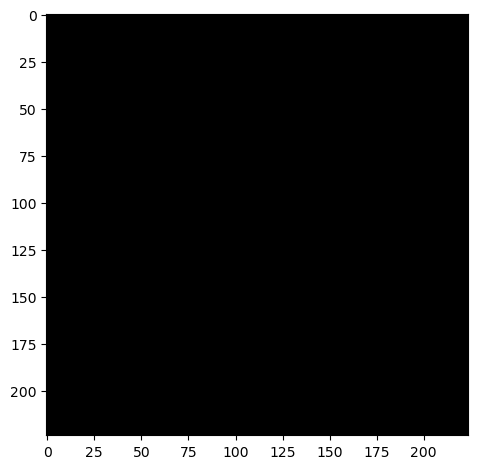

Image number:  373_2


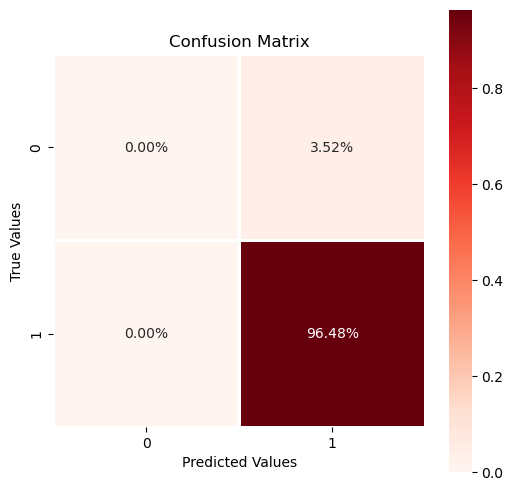

True positive:  0
False positive:  0
False negative:  1767
True negative:  48409


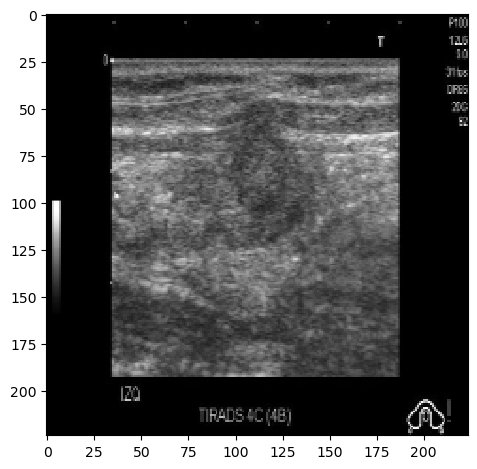

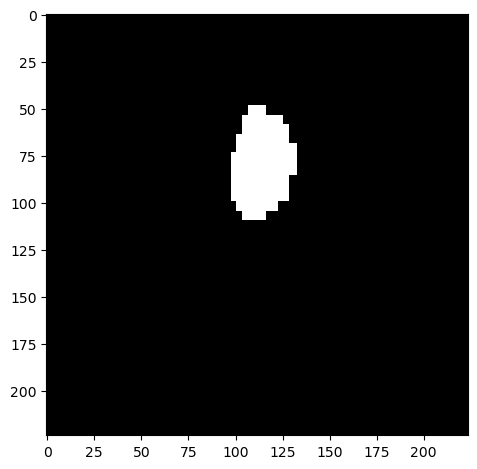

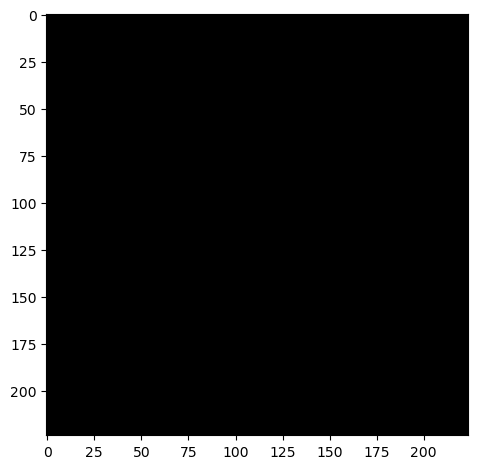

Image number:  371_1


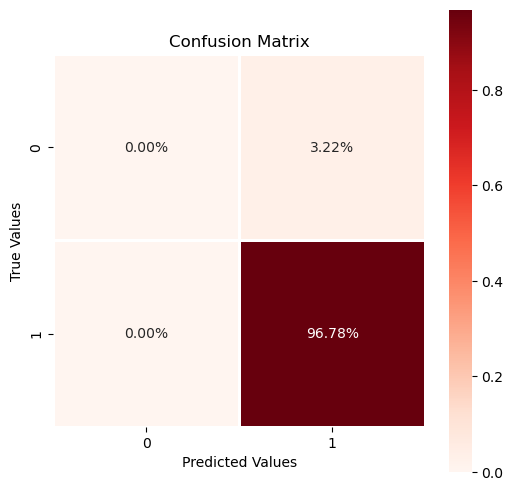

True positive:  0
False positive:  0
False negative:  1614
True negative:  48562


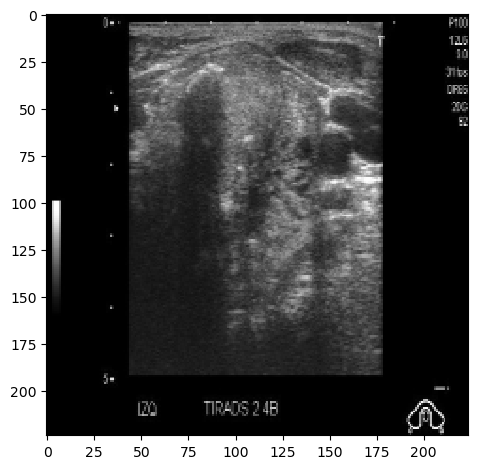

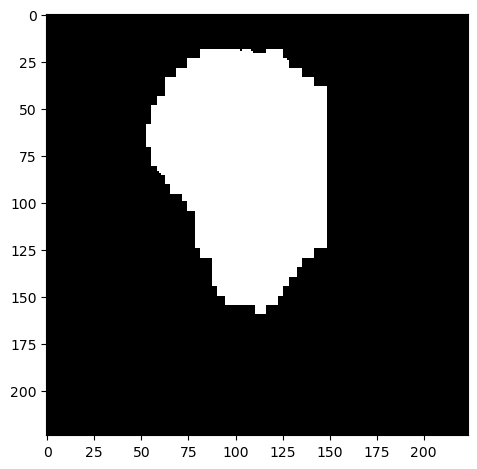

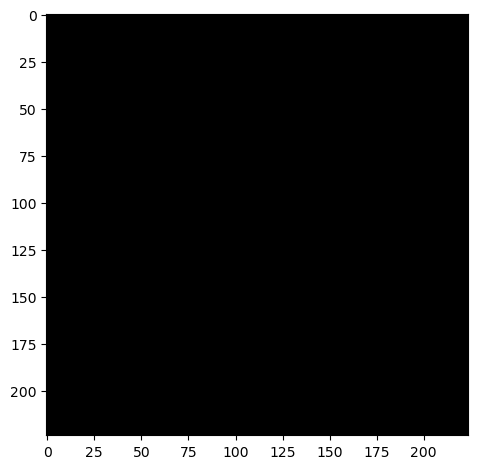

Image number:  396_1


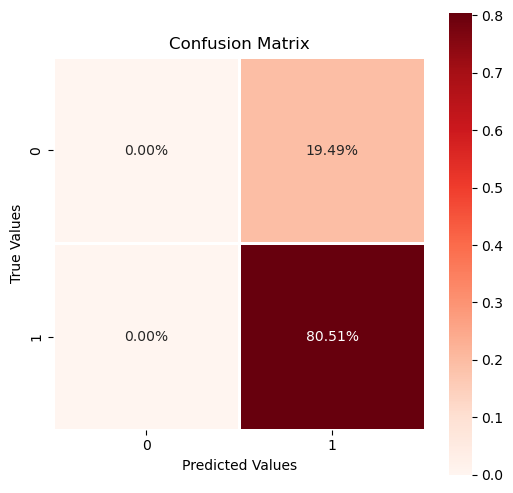

True positive:  0
False positive:  0
False negative:  9780
True negative:  40396


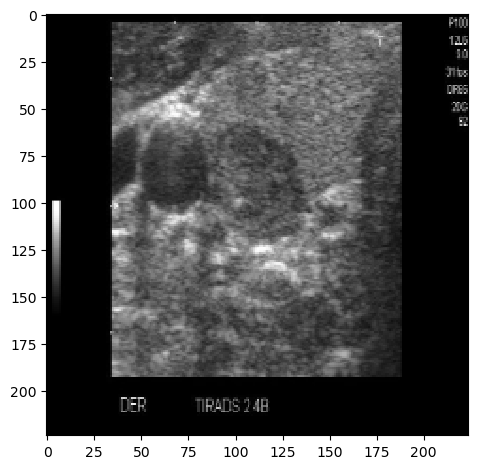

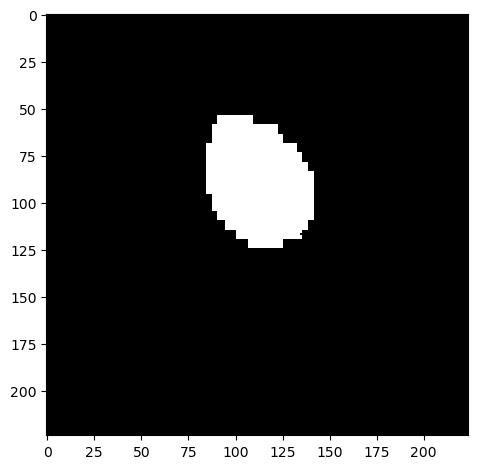

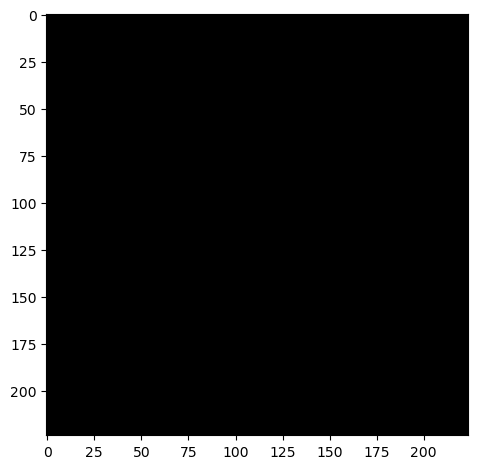

Image number:  360_2


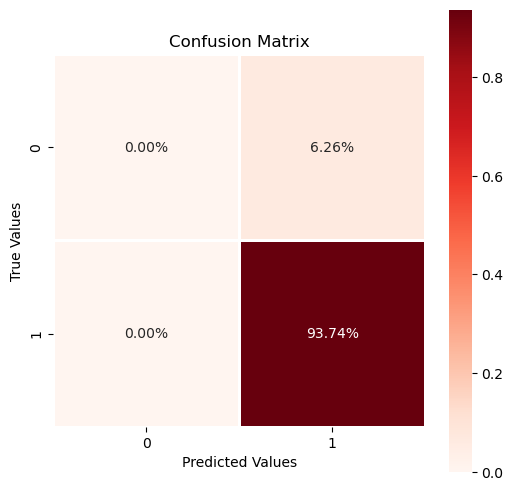

True positive:  0
False positive:  0
False negative:  3139
True negative:  47037


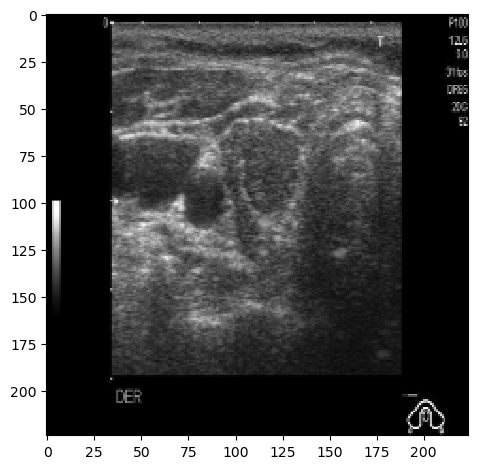

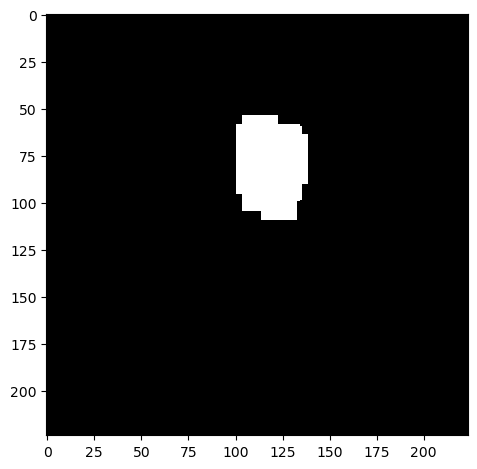

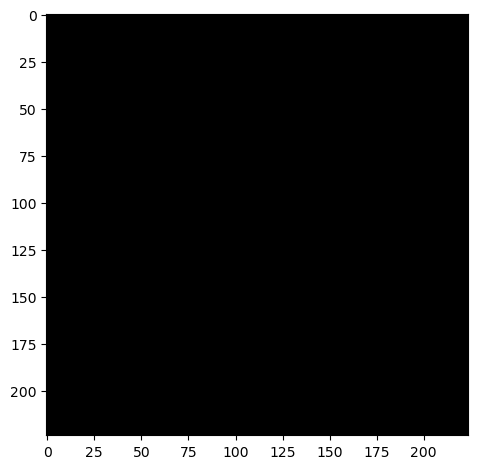

Image number:  368_1


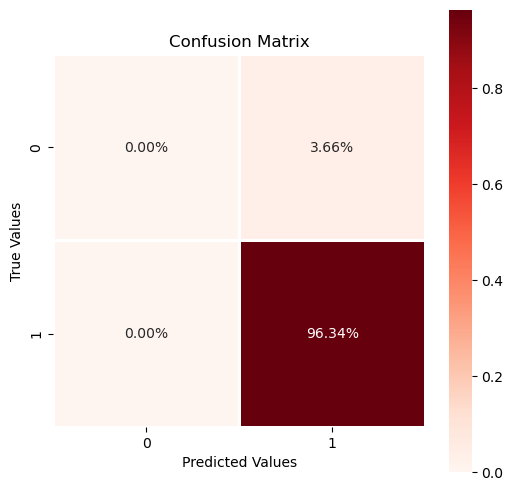

True positive:  0
False positive:  0
False negative:  1837
True negative:  48339


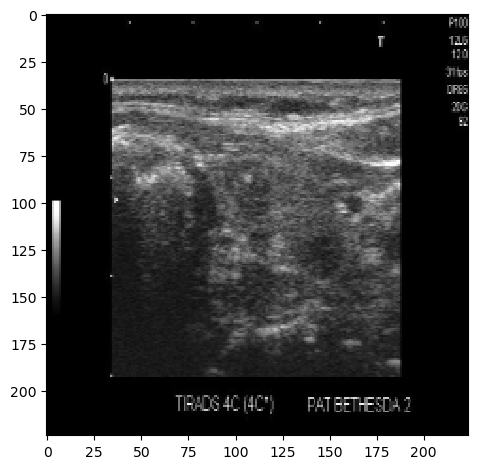

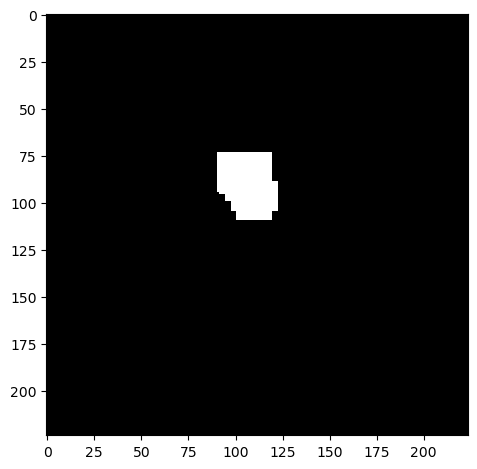

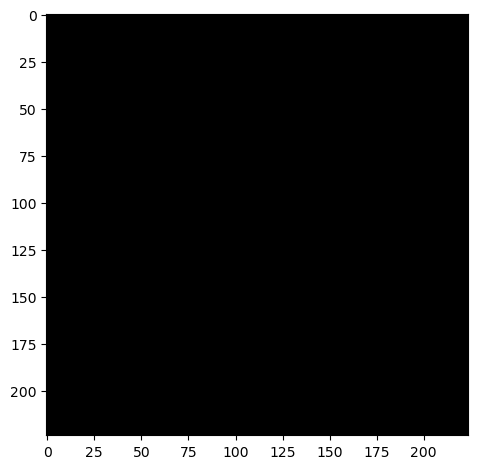

Image number:  387_2


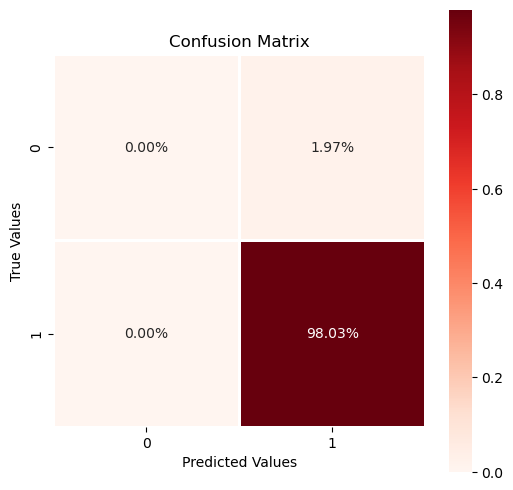

True positive:  0
False positive:  0
False negative:  990
True negative:  49186


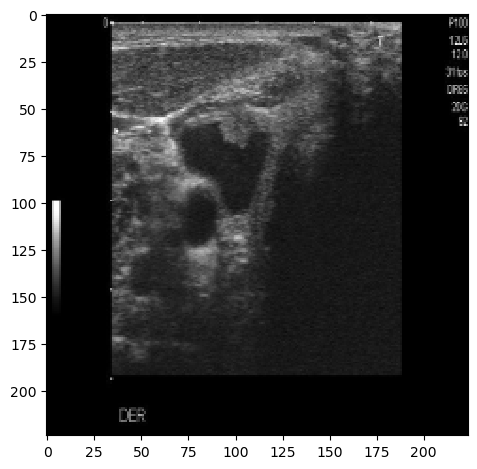

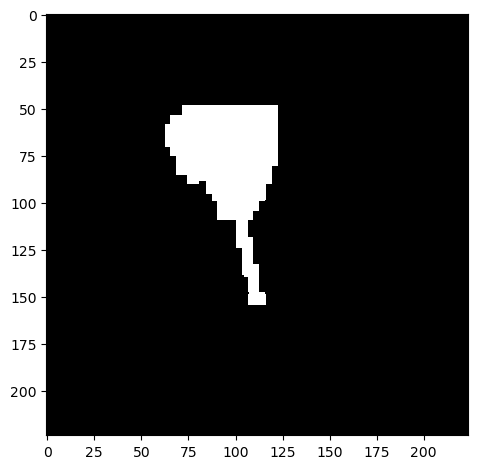

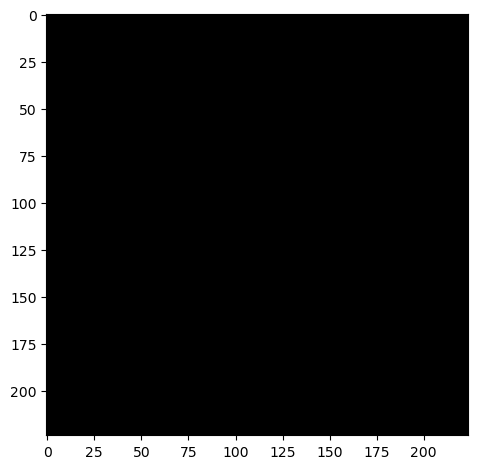

Image number:  362_1


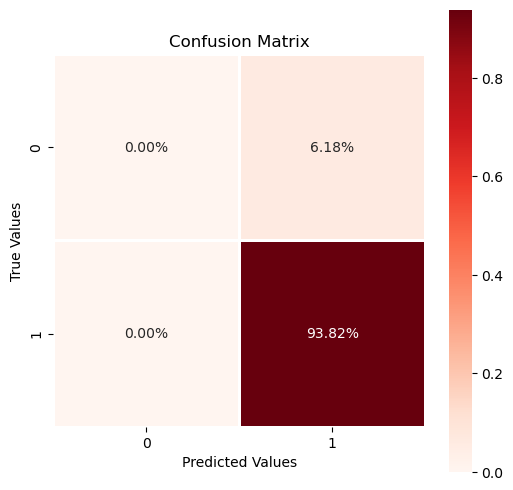

True positive:  0
False positive:  0
False negative:  3101
True negative:  47075


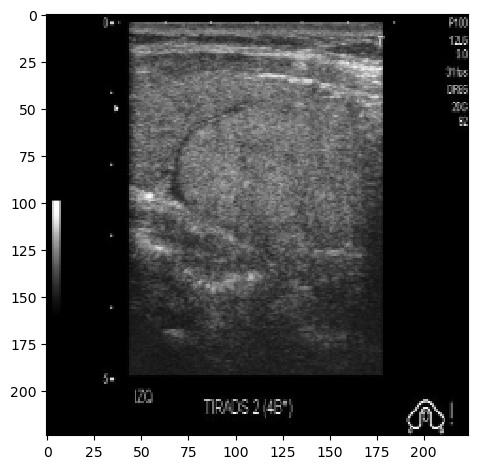

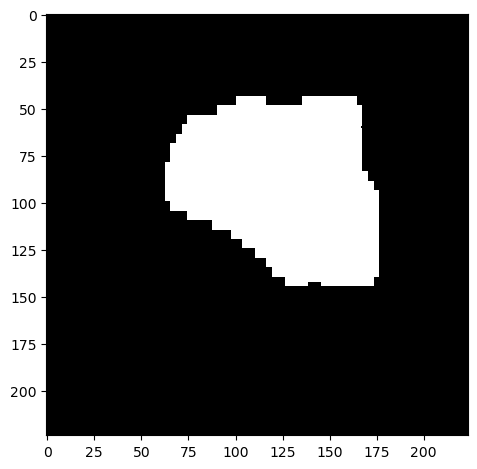

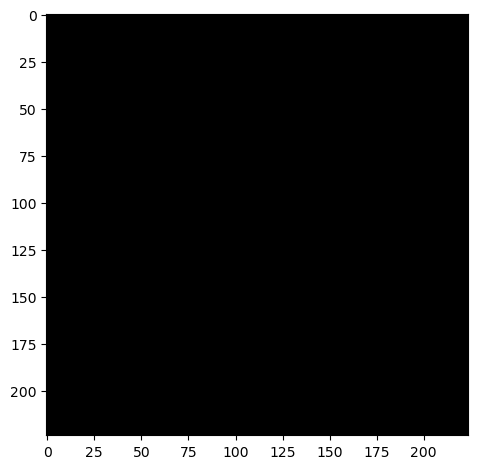

Image number:  366_1


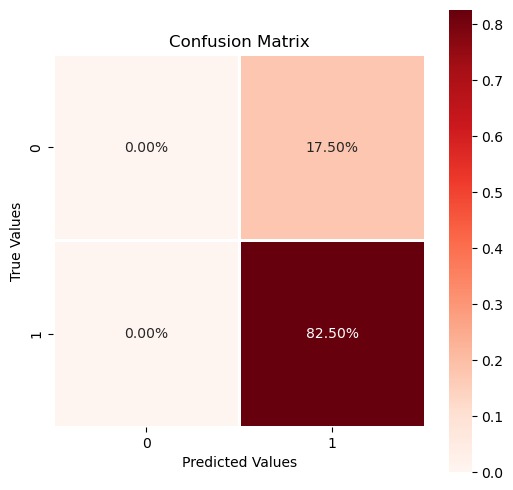

True positive:  0
False positive:  0
False negative:  8779
True negative:  41397


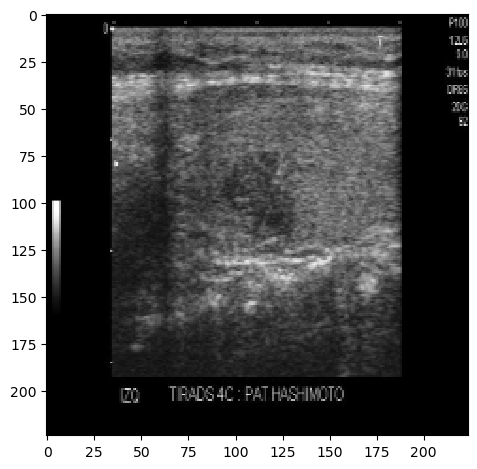

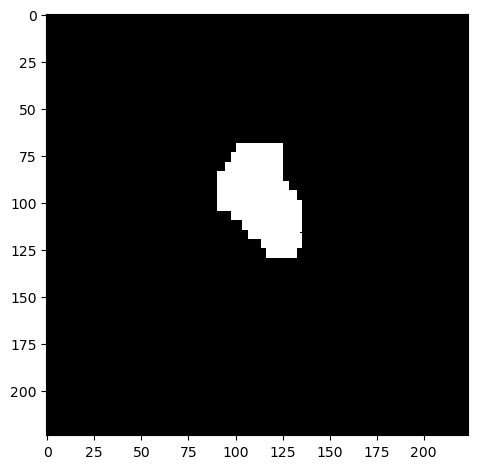

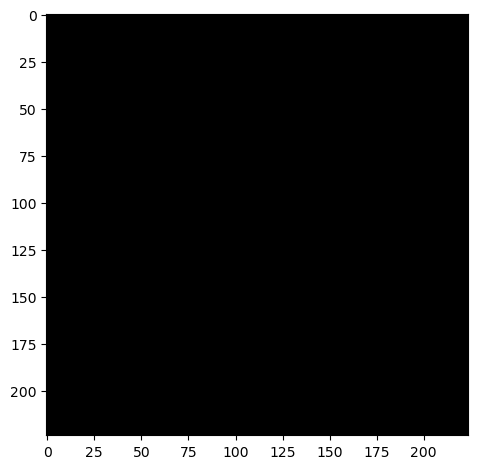

Image number:  381_1


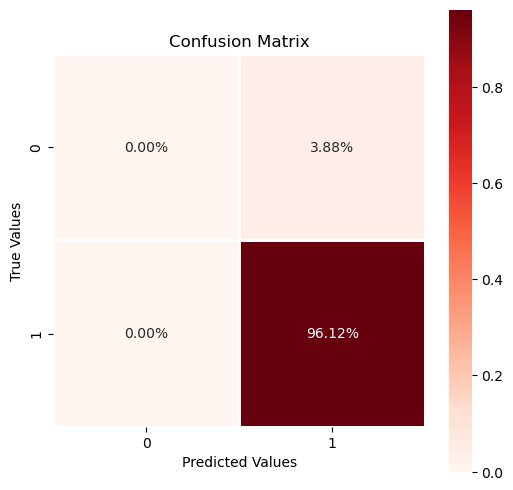

True positive:  0
False positive:  0
False negative:  1949
True negative:  48227


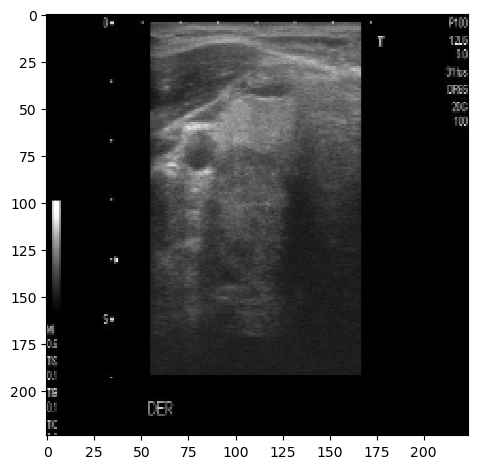

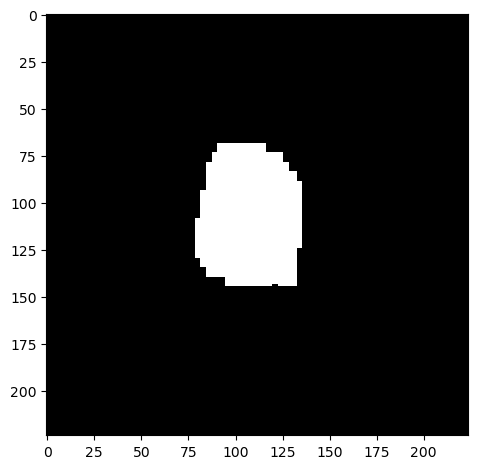

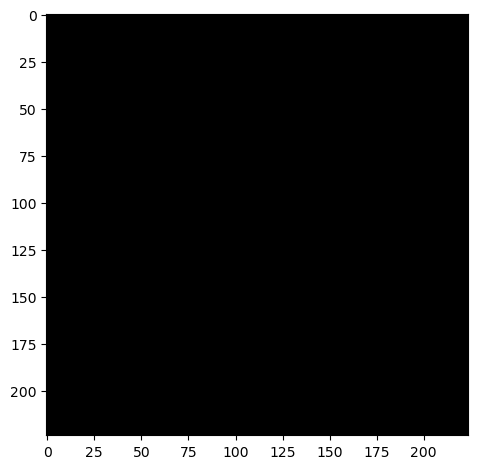

Image number:  376_1


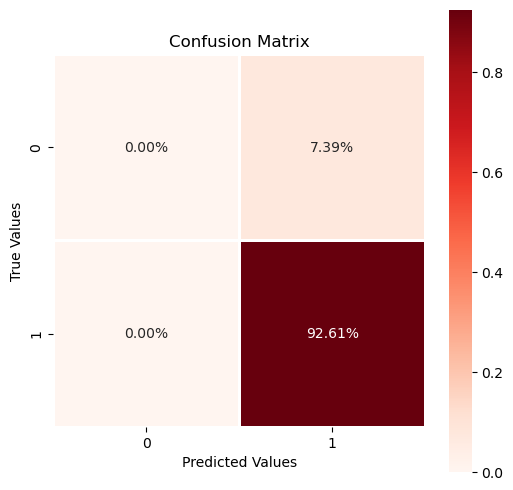

True positive:  0
False positive:  0
False negative:  3709
True negative:  46467


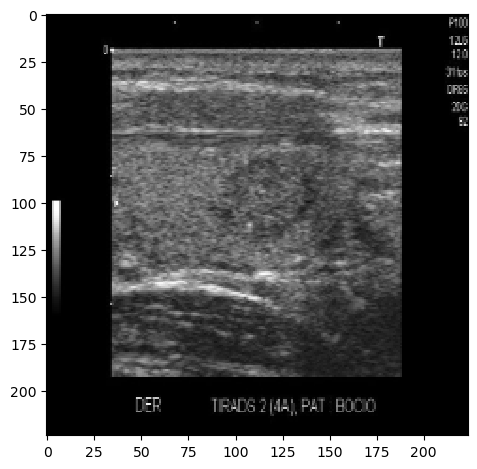

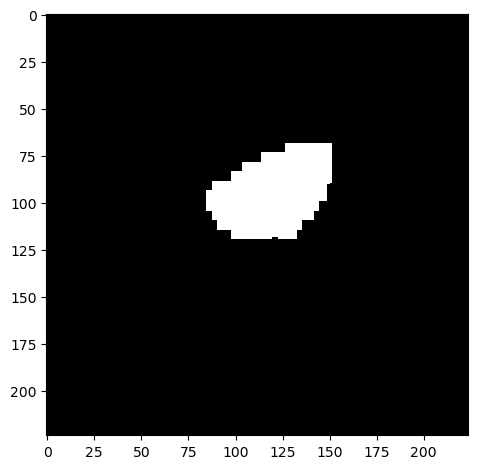

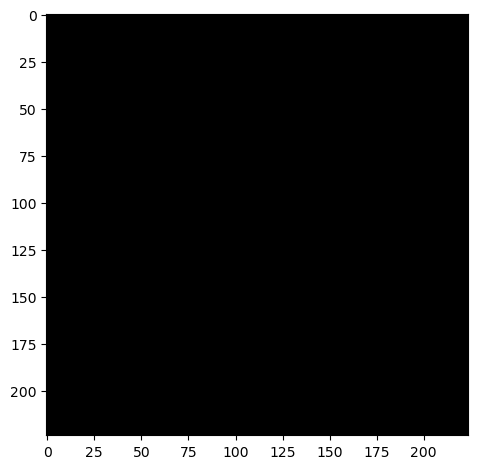

Image number:  391_1


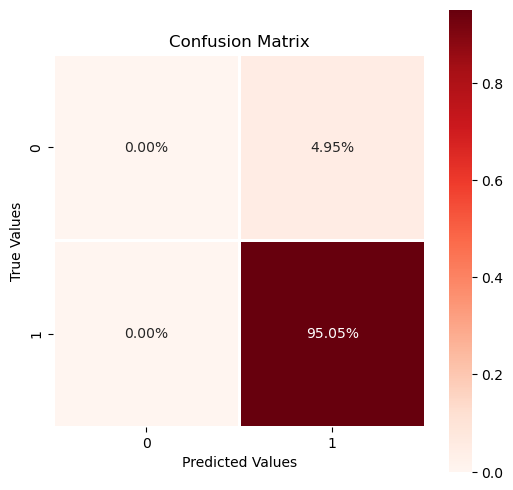

True positive:  0
False positive:  0
False negative:  2486
True negative:  47690


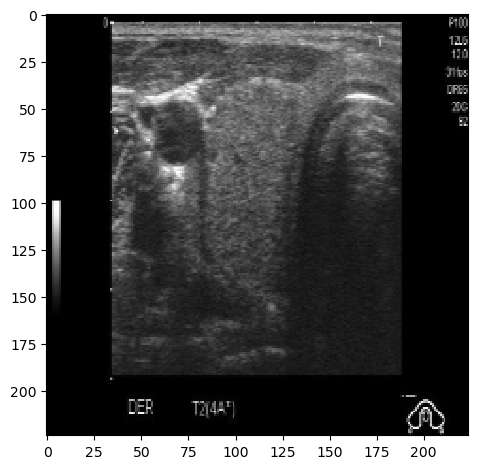

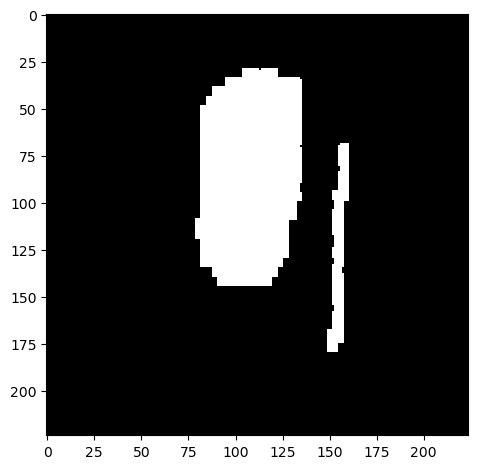

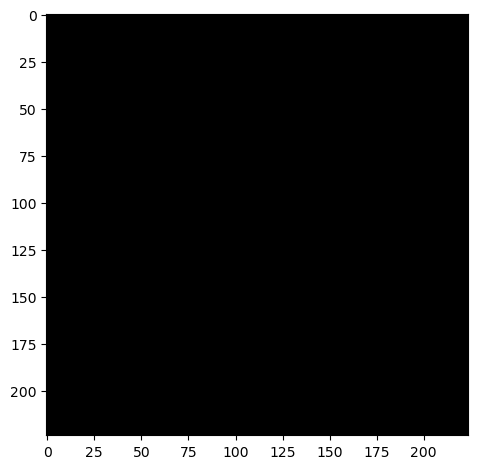

Image number:  378_1


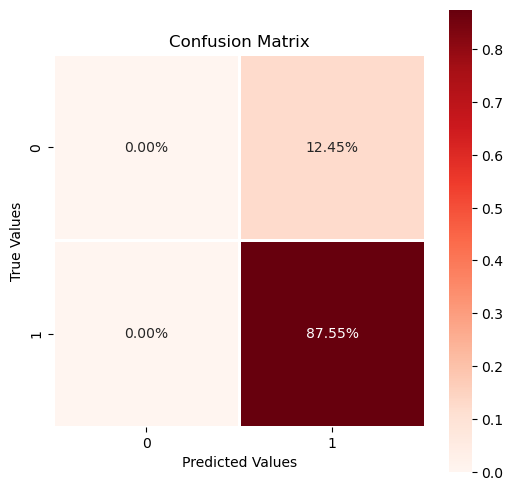

True positive:  0
False positive:  0
False negative:  6245
True negative:  43931


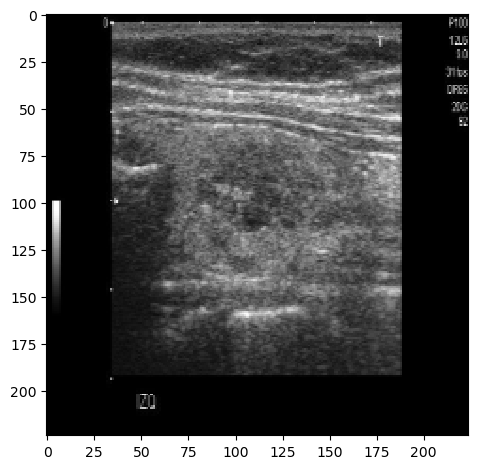

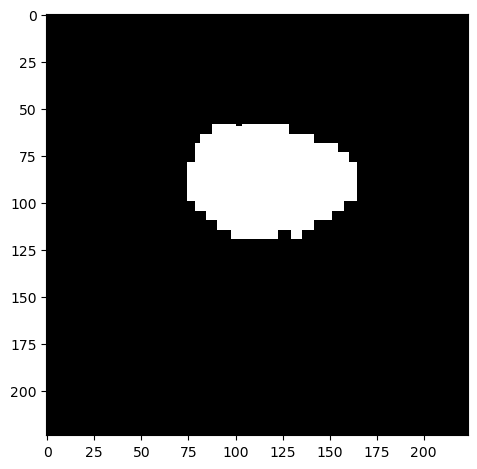

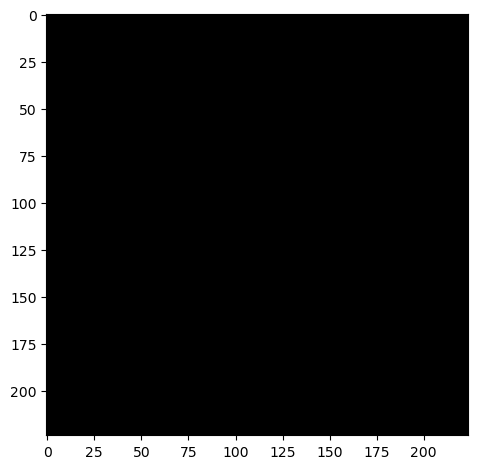

Image number:  372_1


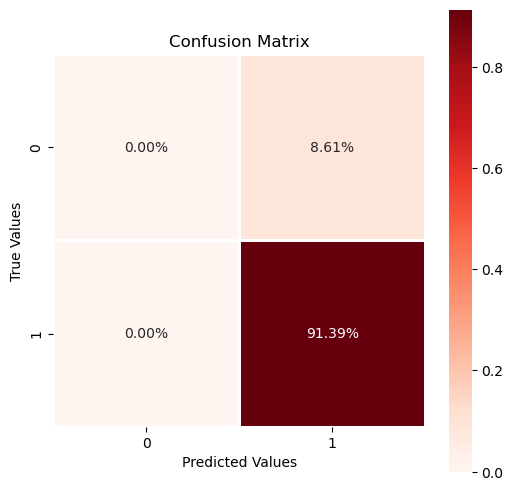

True positive:  0
False positive:  0
False negative:  4322
True negative:  45854


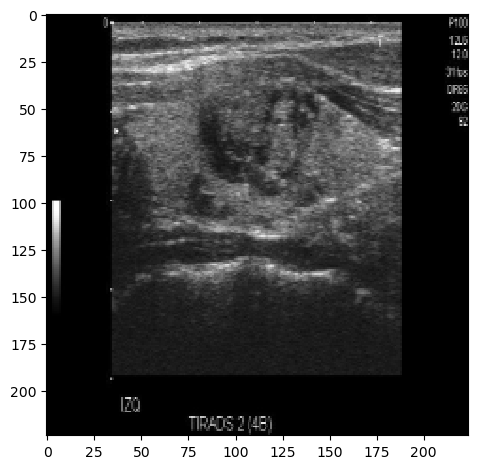

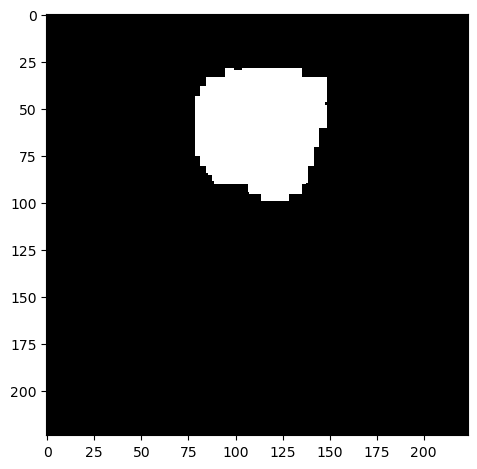

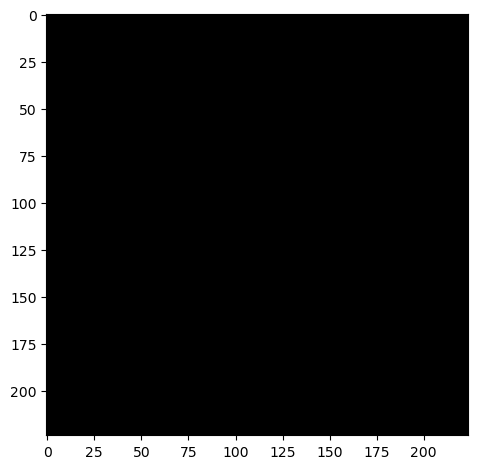

Image number:  395_1


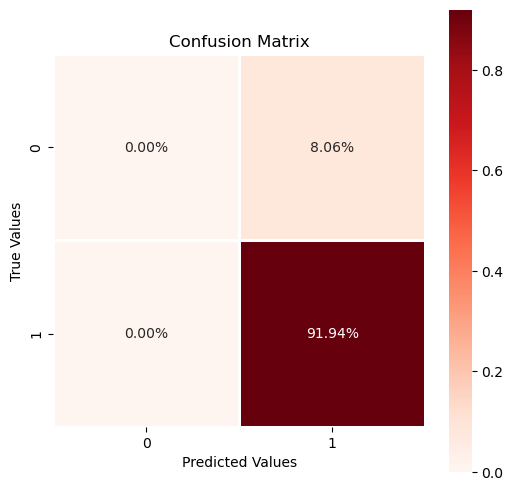

True positive:  0
False positive:  0
False negative:  4044
True negative:  46132
F1:  3.2471276595744683 %
Acc:  89.91440425531914 %
IoU:  1.9972978723404253 %
Dice:  3.2471276595744683 %


In [31]:
# Se alege un numar aleator    
# x = random.randint(0, len(preds_test_t))
# x = 8

iou = 0
iou2 = 0
accuracy = 0
accuracy2 = 0
f1_score2 = 0
f1_score = 0
dice = 0
dice2 = 0

for x in range(len(correspondent_test)):
# Se afiseaza imaginea impreuna cu masca si predictia
    imshow(X_test[x])
    plt.show()
    imshow(np.squeeze(Y_test[x]))
    plt.show()
    imshow(np.squeeze(preds_test_t[x]))
    plt.show()

    print("Image number: ", correspondent_test[x])

    gtMask = Y_test[x]
    predMask = preds_test_t[x]   

    # Get the parameters value 
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(len(gtMask)):
        for j in range(len(gtMask[i])):
            if gtMask[i][j] == True and predMask[i][j] == 1:
                tp += 1
            elif gtMask[i][j] == False and predMask[i][j] == 1:
                fp += 1
            elif gtMask[i][j] == True and predMask[i][j] == 0:
                fn += 1
            elif gtMask[i][j] == False and predMask[i][j] == 0:
                tn += 1

    # Show the Confusion Matrix          
    cmat = [[tp, fn], [fp, tn]]
    plt.figure(figsize = (6,6))
    sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    plt.title("Confusion Matrix")
    plt.show()


    # Print parameters
    print("True positive: ",tp)
    print("False positive: ",fp)
    print("False negative: ",fn)
    print("True negative: ",tn)

    # Calculate the evaluation metrics
    iou2 = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    accuracy2 = (tp + tn) / (tp + fp + fn + tn)
    dice2 = (2 * tp) / ((2 * tp) + fp + fn) if ((2 * tp) + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score2 = (2 * precision * recall)/(precision + recall) if (precision + recall) > 0 else 0

    if np.isnan(dice2):
        dice2 = 0
    if np.isnan(accuracy2):
        accuracy2 = 0
    if np.isnan(f1_score2):
        f1_score2 = 0
    if np.isnan(iou2):
        iou2 = 0
    
    iou2 = round(iou2*100, 3)
    accuracy2 = round(accuracy2*100, 3)
    f1_score2 = round(f1_score2*100, 3)
    dice2 = round(dice2*100, 3)
    
    iou = iou + iou2
    accuracy = accuracy + accuracy2
    f1_score = f1_score + f1_score2
    dice = dice + dice2
    
    # Print the evaluation metrics

print("F1: ", f1_score/len(correspondent_test), "%")
print("Acc: ", accuracy/len(correspondent_test), "%")    
print("IoU: ", iou/len(correspondent_test), "%")
print("Dice: ", dice/len(correspondent_test), "%")


In [ ]:

# Se alege un numar aleator    
x = random.randint(0, len(preds_test_t))

# Se afiseaza imaginea impreuna cu masca si predictia
imshow(X_test[x])
plt.show()
imshow(np.squeeze(Y_test[x]))
plt.show()
imshow(np.squeeze(preds_test_t[x]))
plt.show()
print("Image number: ",x)

gtMask = Y_test[x]
predMask = preds_test_t[x]   

# Get the parameters value 
tp = 0
fp = 0
fn = 0
tn = 0

for i in range(len(gtMask)):
    for j in range(len(gtMask[i])):
        if gtMask[i][j] == True and predMask[i][j] == 1:
            tp += 1
        elif gtMask[i][j] == False and predMask[i][j] == 1:
            fp += 1
        elif gtMask[i][j] == True and predMask[i][j] == 0:
            fn += 1
        elif gtMask[i][j] == False and predMask[i][j] == 0:
            tn += 1

# Show the Confusion Matrix          
cmat = [[tp, fn], [fp, tn]]
plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.title("Confusion Matrix")
plt.show()

# Print parameters
print("True positive: ",tp)
print("False positive: ",fp)
print("False negative: ",fn)
print("True negative: ",tn)

# Calculate the evaluation metrics
iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
accuracy = (tp + tn) / (tp + fp + fn + tn)
dice = (2 * tp) / ((2 * tp) + fp + fn) if ((2 * tp) + fp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = (2 * precision * recall)/(precision + recall) if (precision + recall) > 0 else 0

# Print the evaluation metrics
print("Dice: ", round(dice*100, 3), "%")
print("Acc: ", round(accuracy*100, 3), "%")    
print("IoU: ", round(iou*100, 3), "%")
print("F1: ", round(f1_score*100, 3), "%")